In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime

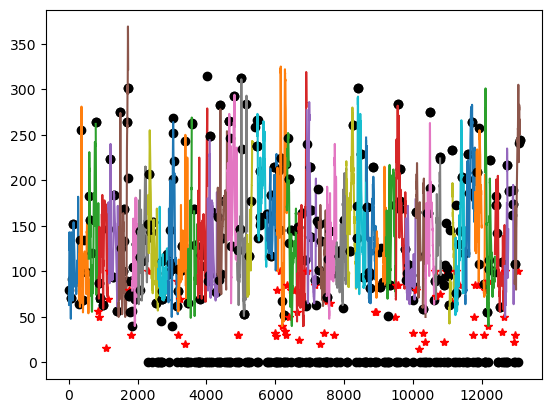

In [91]:
# Load the dataset
df = pd.read_csv("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")
# Start time samples from zero
df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]

filtered_df_carbs = df[df["carbInput"].notnull()]
filtered_df_finger = df[df["finger"].notnull()]
for i in range(13*4):
    start = i*288
    end = (i+1)*288
    # plt.figure()
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["carbInput"][start:end], "r*", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["finger"][start:end], "ko", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["cbg"][start:end], label="CarbInput")

In [278]:
def append_if_in_range(subset_a, subset_b, distance=6, bolus = False):
    ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
    # Function to check if the index is within any range
    def in_any_range(idx):
        return any(start <= idx <= end for start, end in ranges)
    
    # Create a new dataframe for valid entries in subset B
    valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
    
    # Append the valid rows from subset B to subset A
    temp = pd.concat([subset_a, valid_b], join="outer").sort_index().drop_duplicates()

    # List of index values where we want to split the DataFrame
    split_indices = valid_b.index.to_list() # The DataFrame will be split at index 3 and 6
    # Initialize the starting point of the split
    start_idx = subset_a.index.to_list()[0]
    # Initialize an empty list to hold the sub-DataFrames
    sub_dfs = []

    # Iterate through the split indices and slice the DataFrame
    for idx in split_indices:
        sub_dfs.append(temp.loc[start_idx:idx-1].copy())
        start_idx = idx

    # Append the last section of the DataFrame (from last split point to end)
    sub_dfs.append(temp.loc[start_idx:].copy())

    # Show the resulting sub-DataFrames
    if not bolus:
        for sub_df in sub_dfs:
            values = sub_df.index.to_list()
            sub_df["minAfterMeal"] = [(x-values[0])*5 for x in values]
    else:
        for sub_df in sub_dfs:
            values = sub_df.index.to_list()
            sub_df["minAfterBolus"] = [(x-values[0])*5 for x in values]

    result = pd.concat(sub_dfs)
    
    return result

In [315]:
# List of DataFrame indexes 
carbIntake = []

# Filter for carb intake, where carb intake is not null
filtered_df_carbs = df[df["carbInput"].notnull()]
filtered_df_bolus= df[df["bolus"].notnull()]
filtered_df_hr = df[df["hr"].notnull()]
sampling_time = 5
nbr_of_mins = 10
nbr_of_hours = 3
nbr_of_lags = 3
nbr_of_time_steps =int(nbr_of_mins/sampling_time)
nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

for index, row in filtered_df_carbs.iterrows():
    filtered_df_carbs = filtered_df_carbs.drop(filtered_df_carbs.index.to_list()[0])
    carbIntakePerIndex = []
    for i in range(nbr_of_total_samples):
        try:
            carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
        except:
            print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
            break
    # Create the Data Frame
    carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
        
    # Include all indeces of further carb intakes between the indeces
    carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
    # carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_bolus)
    

    # Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
    lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag*nbr_of_time_steps).bfill() for lag in range(1, nbr_of_lags)}
    carbIntakePerIndex_df = carbIntakePerIndex_df.assign(**lagged_features)
    if carbIntakePerIndex_df["missing_cbg"].any() > 0:
        continue

    carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).set_index((x-carbIntakePerIndex_df.index.tolist()[0])*5 for x in carbIntakePerIndex_df.index.tolist()))

    


In [316]:
carbIntake[0]

missing_cbg    cbg  finger  basal   hr       gsr  carbInput  bolus  \
0            0.0   84.0     0.0   0.95  0.0  0.007625       57.0    0.0   
10           0.0   78.0     0.0   0.95  0.0  0.000000        0.0    0.0   
20           0.0   72.0     0.0   0.95  0.0  0.024066        0.0    0.0   
30           0.0   68.0     0.0   0.95  0.0  0.006154        0.0    0.0   
40           0.0   91.0     0.0   0.95  0.0  0.008535        0.0    6.3   
50           0.0  136.0     0.0   0.95  0.0  0.011371        0.0    0.0   
60           0.0  161.0     0.0   0.95  0.0  0.010671        0.0    0.0   
70           0.0  175.0     0.0   0.95  0.0  0.012545        0.0    0.0   
80           0.0  163.0     0.0   0.95  0.0  0.010346        0.0    0.0   
90           0.0  138.0     0.0   0.95  0.0  0.015037        0.0    0.0   
100          0.0  112.0     0.0   0.00  0.0  0.018316        0.0    0.0   
110          0.0   98.0     0.0   0.00  0.0  0.039905        0.0    0.0   
120          0.0   91.0     0.0   0.00  0.0  0.027709        0.0    0.0   
130          0.0   81.0     0.0   0.00  0.0  0.018291        0.0    0.0   
140          0.0   82.0    87.0   0.00  0.0  0.071220        0.0    0.0   
150          0.0   73.0     0.0   0.95  0.0  0.096926       50.0    0.0   
160          0.0   73.0     0.0   0.95  0.0  0.014397        0.0    0.0   
170          0.0   96.0     0.0   0.95  0.0  0.000000        0.0    0.0   

     minAfterMeal  glucose_lag_1  glucose_lag_2  
0               0          106.0          121.0  
10             10           84.0          106.0  
20             20           78.0           84.0  
30             30           72.0           78.0  
40             40           68.0           72.0  
50             50           91.0           68.0  
60             60          136.0           91.0  
70             70          161.0          136.0  
80             80          175.0          161.0  
90             90          163.0          175.0  
100           100          138.0          163.0  
110           110          112.0          138.0  
120           120           98.0          112.0  
130           130           91.0           98.0  
140           140           81.0           91.0  
150             0           82.0           81.0  
160            10           73.0           82.0  
170            20           73.0           73.0

In [317]:
X_train, X_test = train_test_split(carbIntake, test_size=0.33, random_state=42)

In [307]:
def train_model(data, model, train = True):
    # Random seed from reproducibility
    # random.Random(42).shuffle(carbIntake)
    # Perform train-test split on the combined DataFrame
    

    # Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
    scaler = MinMaxScaler()

    X_train = data.drop(["cbg"], axis=1)
    y_train = data["cbg"]

    carbInput = data[data["carbInput"] > 0]

    X_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

    # carbInput = train[train["carbInput"] > 0]
    carbInput_scaled = scaler.fit_transform(carbInput["carbInput"].values.reshape(-1, 1))

    # Linear Regression
    # Train the linear regression model on the scaled data
    if train:
        model.fit(X_train_scaled, y_train_scaled)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)

    # SVR model
    # model = SVR(kernel='rbf', gamma=0.3, C=10, epsilon=0.4)

    # # Fit the model
    # model.fit(X_train, y_train)
    # y_train_pred = model.predict(X_train).reshape(-1,1)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(X_train.index, y_train_scaled, label="Ground Truth")
    axs[0].plot(X_train.index,y_train_pred, label="Prediction")
    axs[0].plot(carbInput.index, carbInput_scaled, "ro")
    axs[1].bar(X_train.columns.values, model.coef_[0])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    axs[0].legend()

    return  model.coef_[0]
    
    # plt.legend()

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_55081/219684867.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

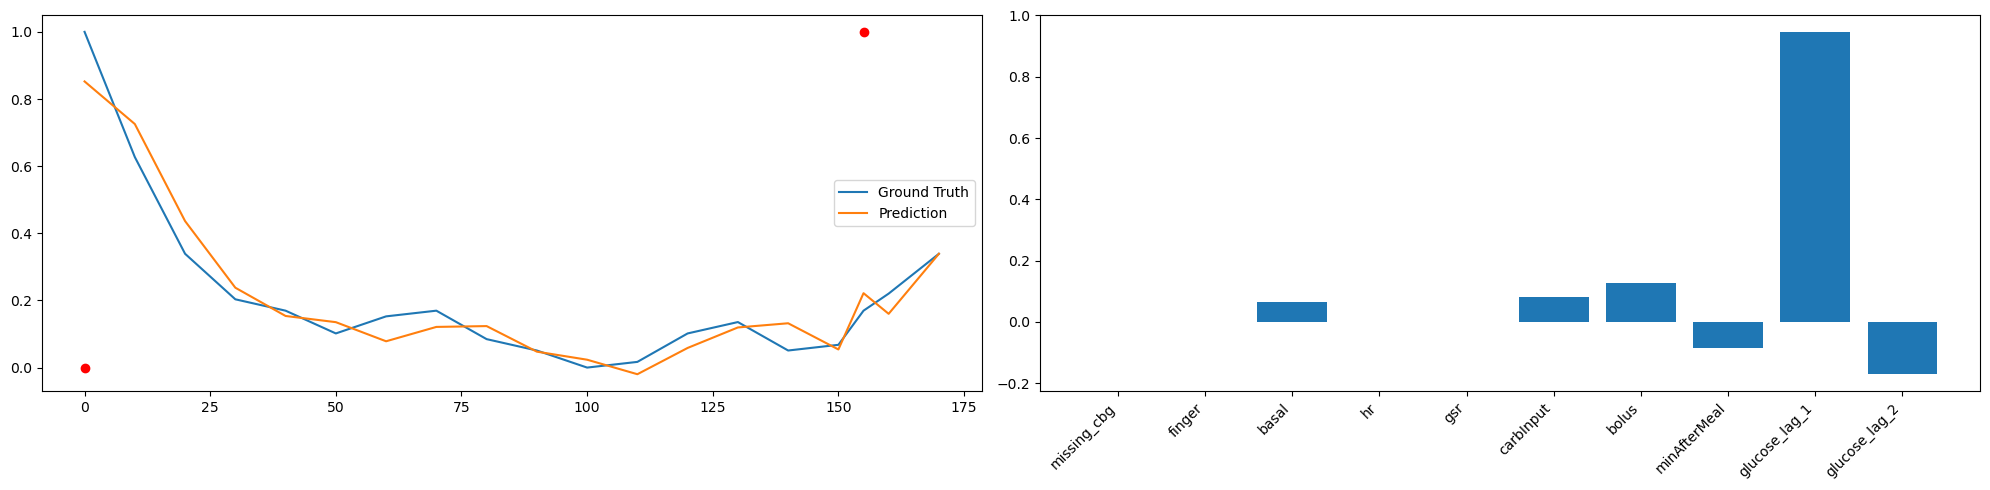

<Figure size 640x480 with 0 Axes>

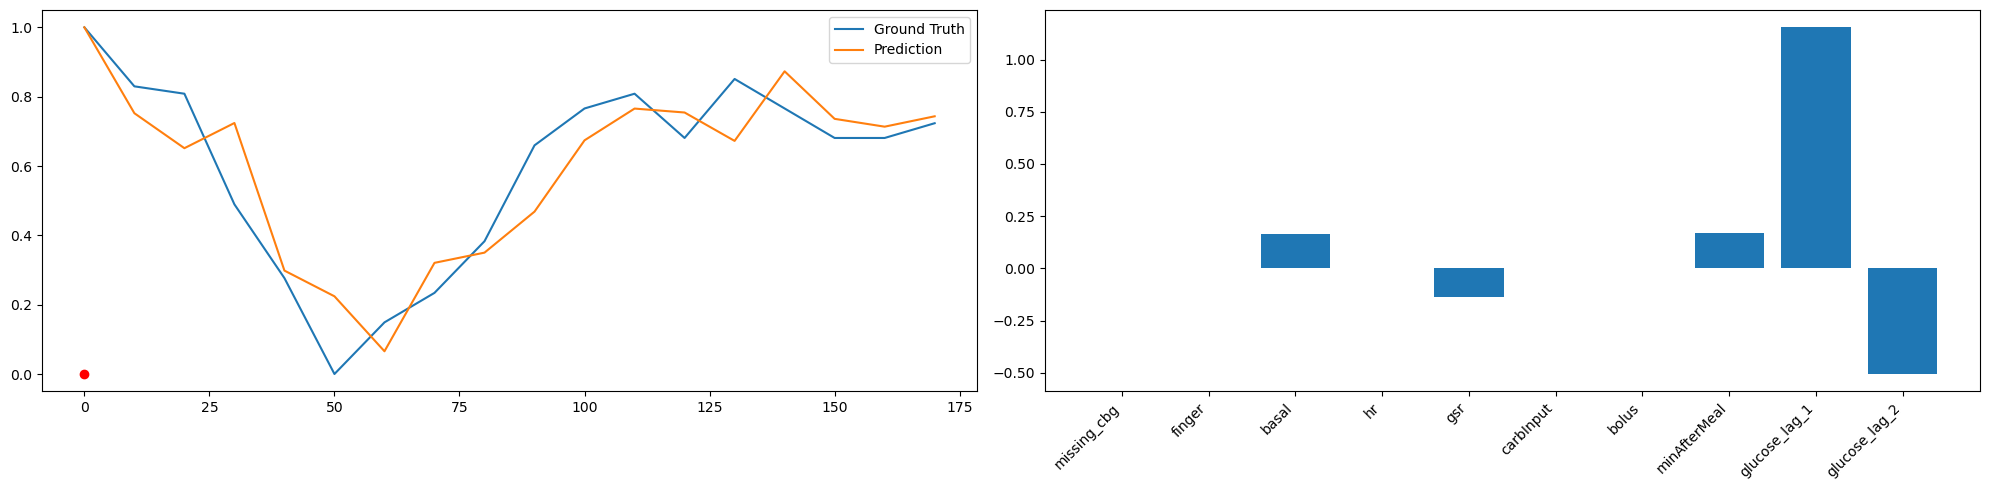

<Figure size 640x480 with 0 Axes>

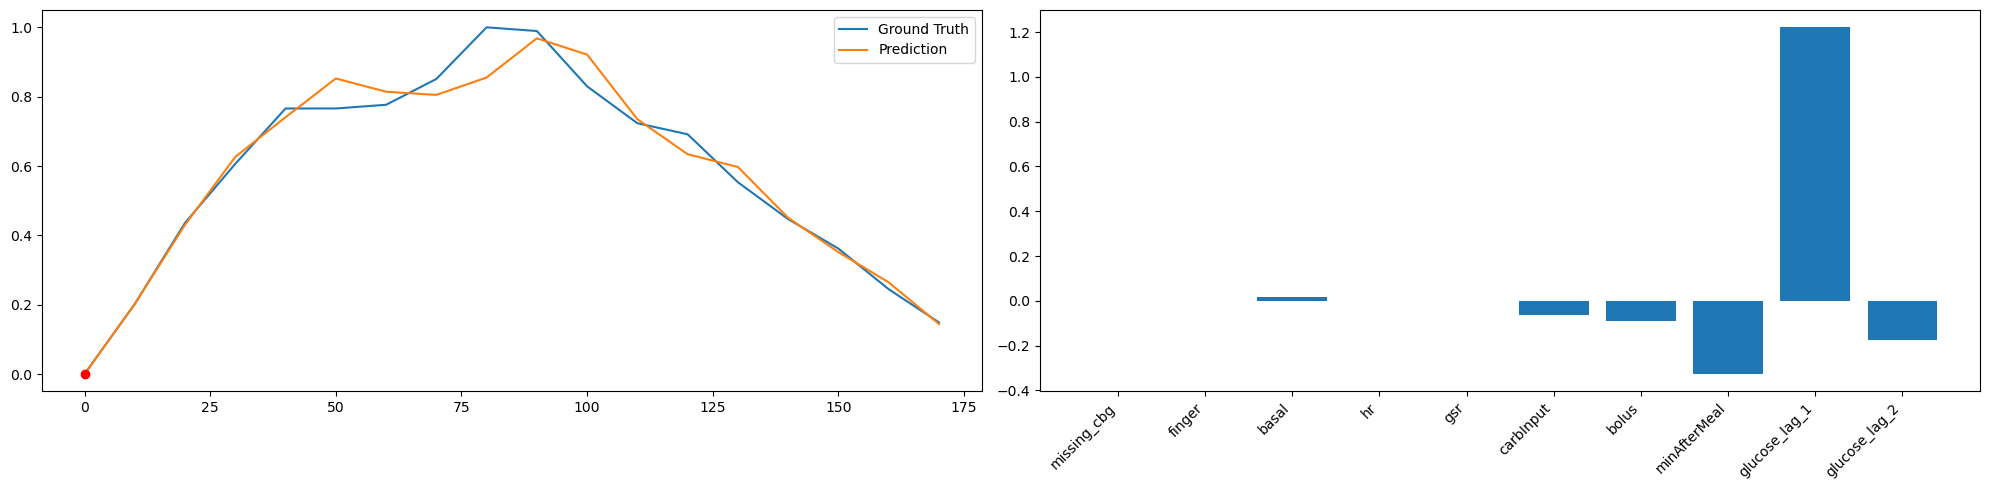

<Figure size 640x480 with 0 Axes>

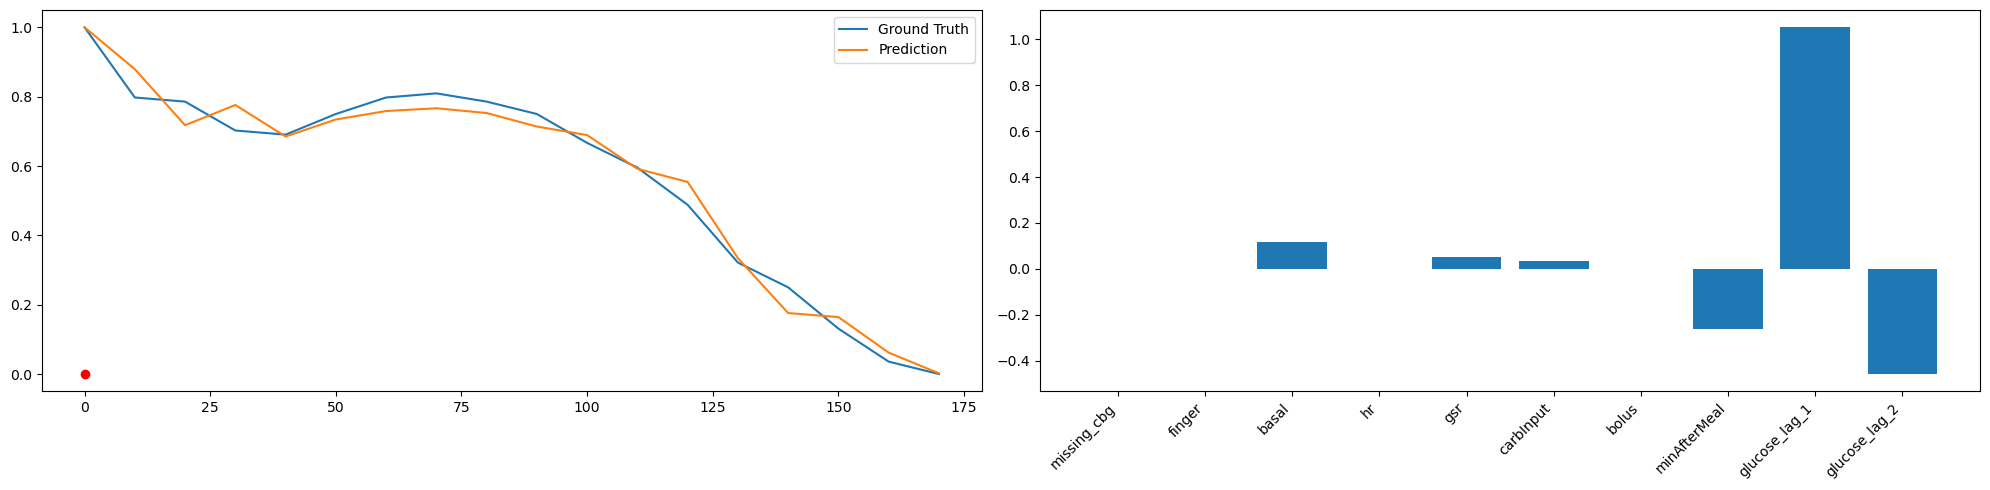

<Figure size 640x480 with 0 Axes>

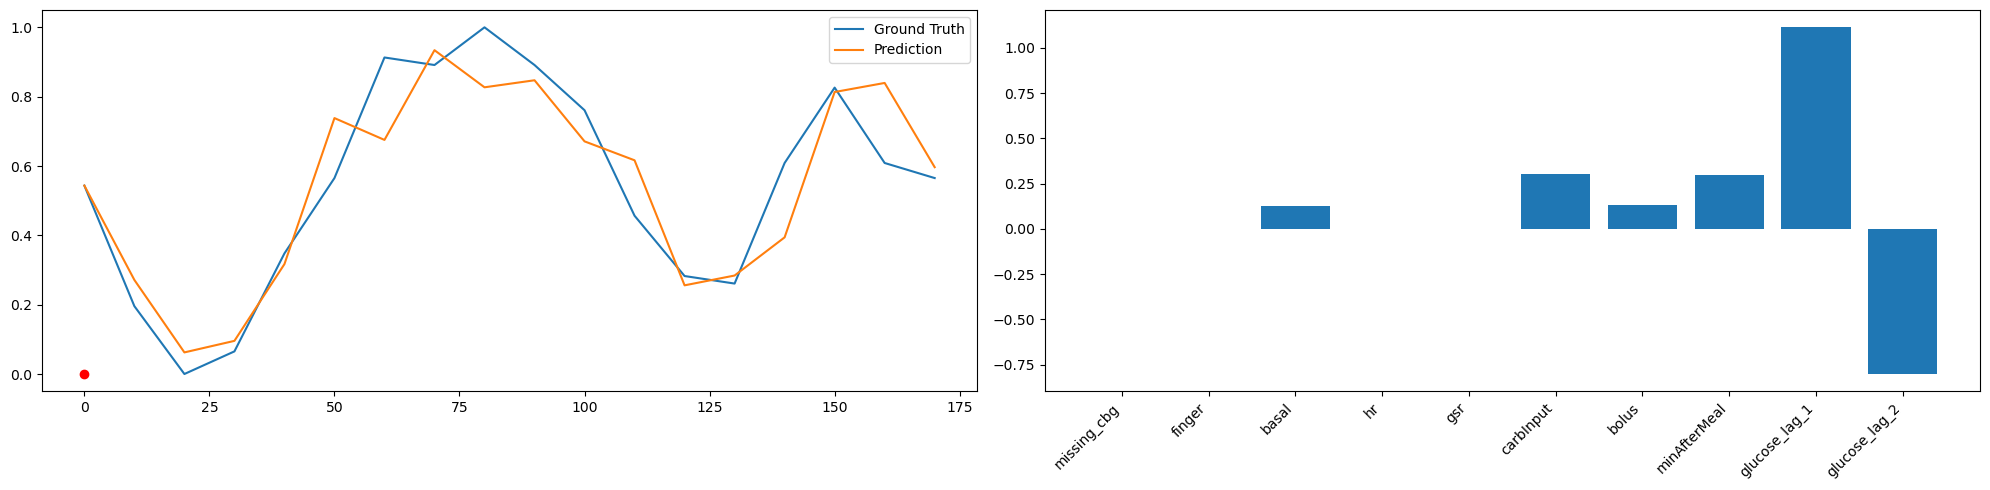

<Figure size 640x480 with 0 Axes>

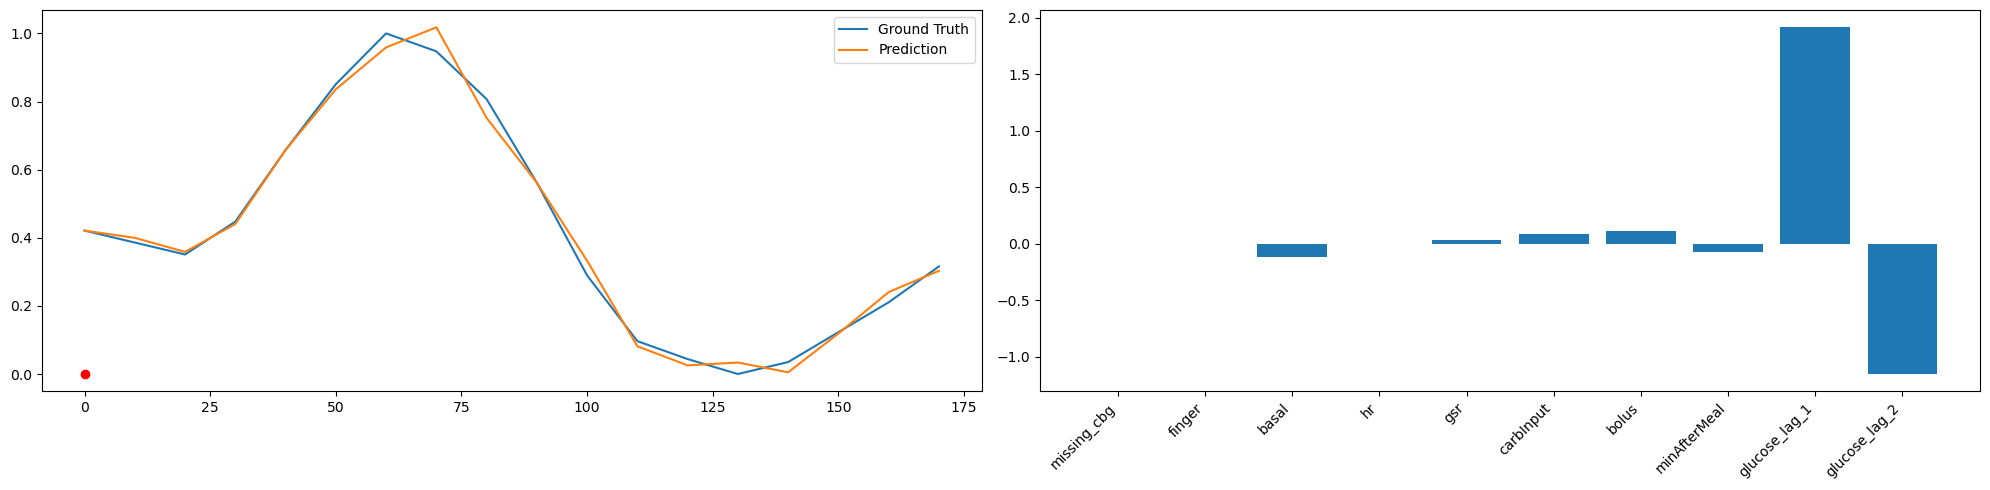

<Figure size 640x480 with 0 Axes>

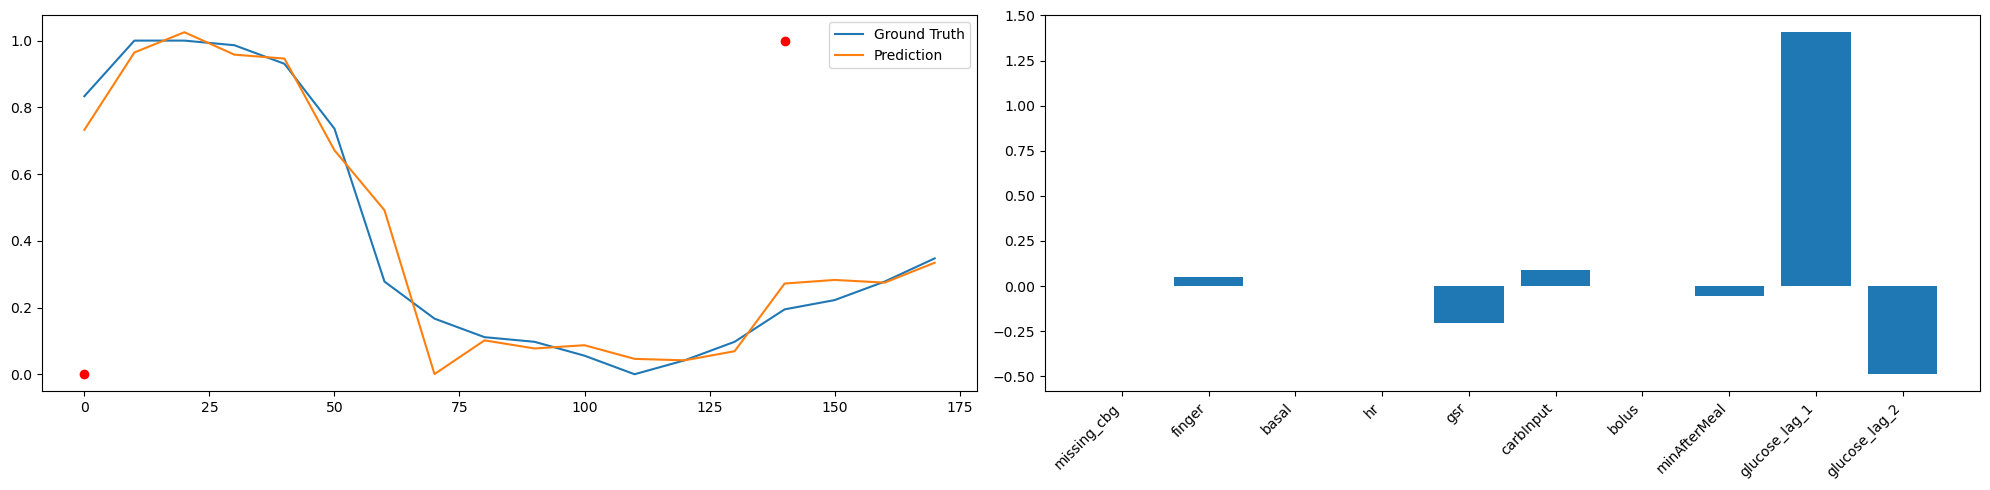

<Figure size 640x480 with 0 Axes>

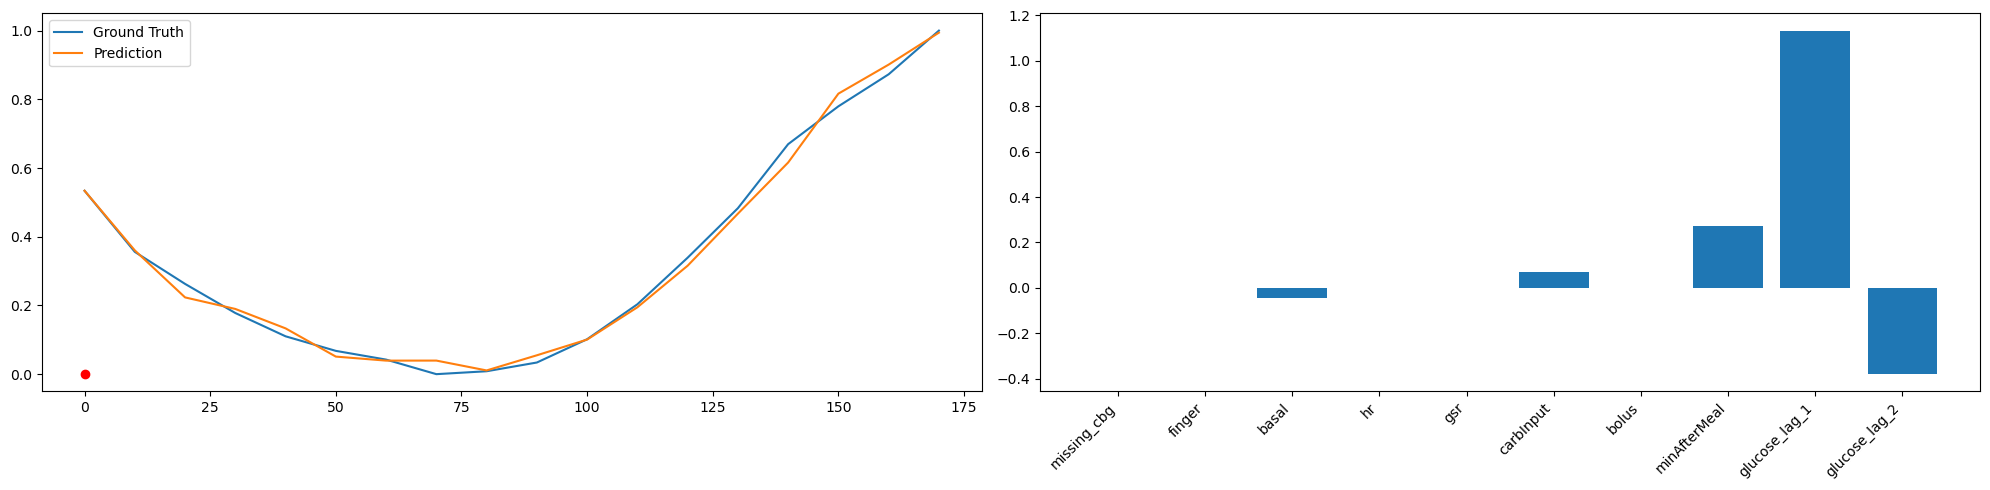

<Figure size 640x480 with 0 Axes>

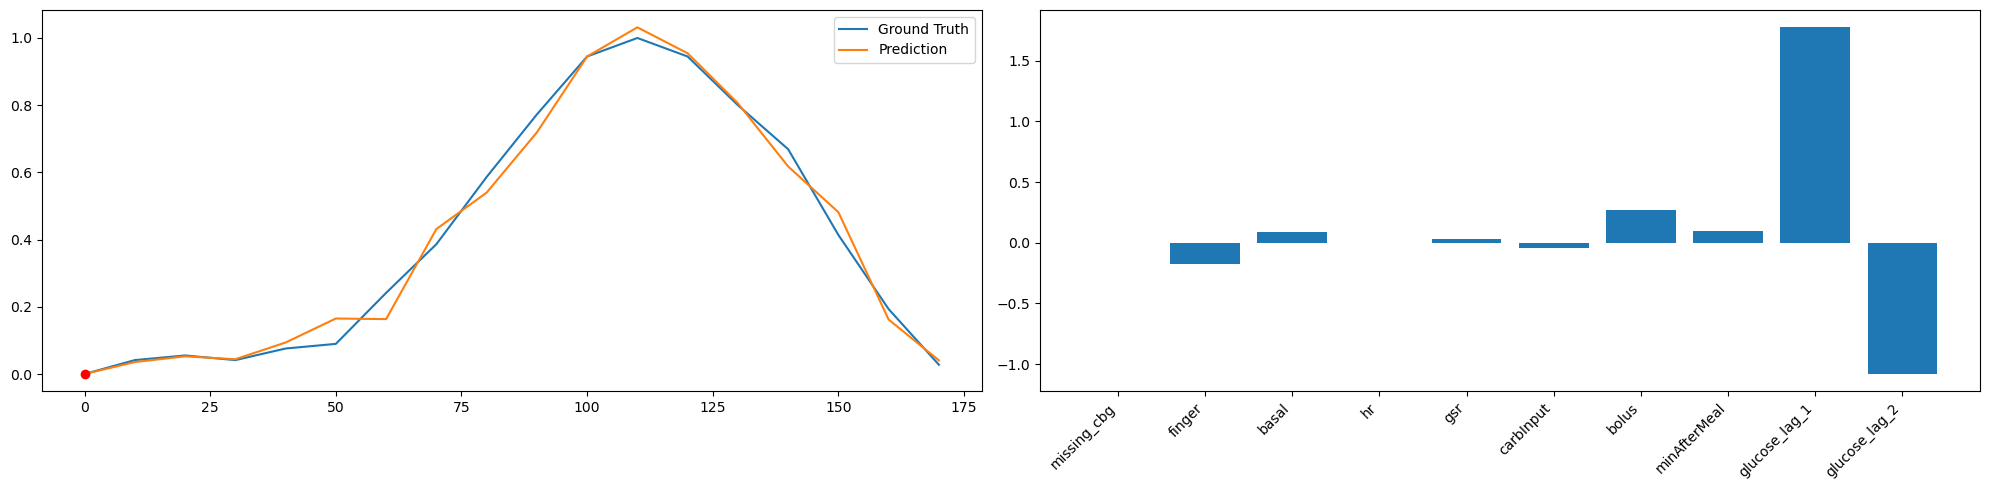

<Figure size 640x480 with 0 Axes>

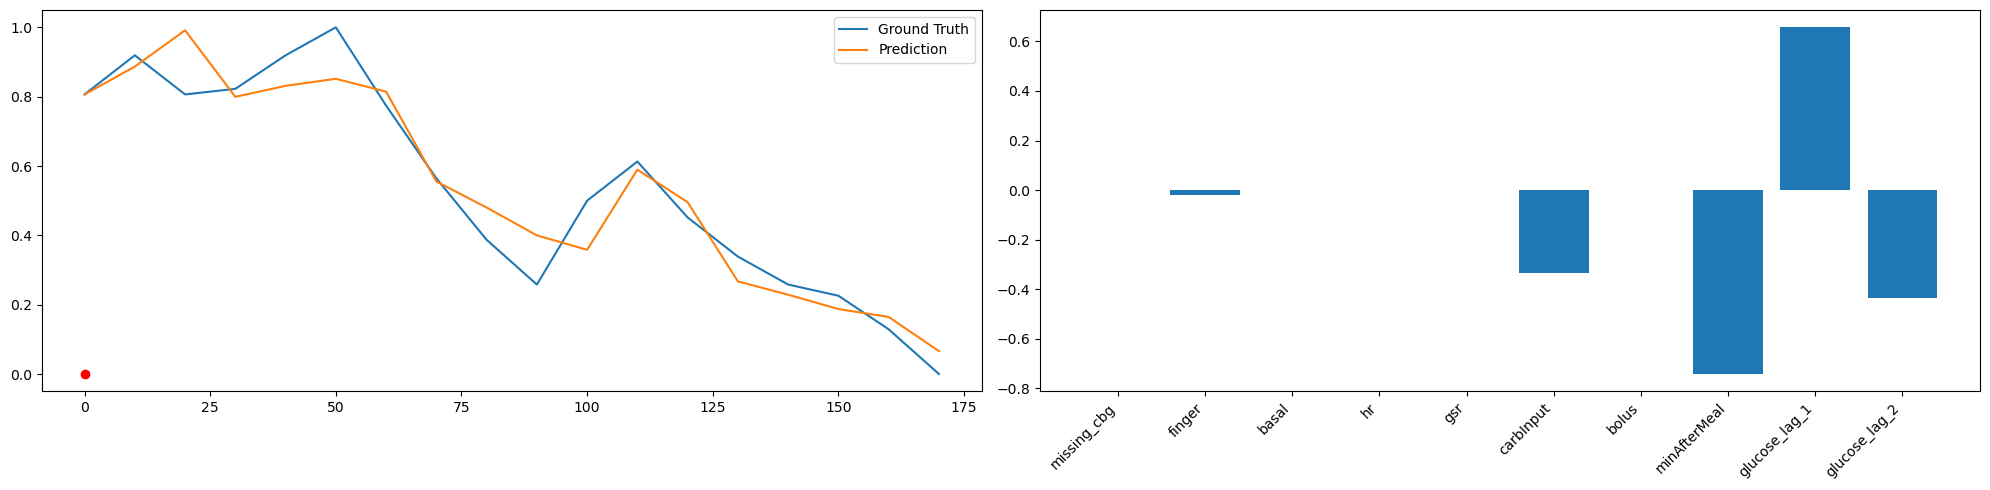

<Figure size 640x480 with 0 Axes>

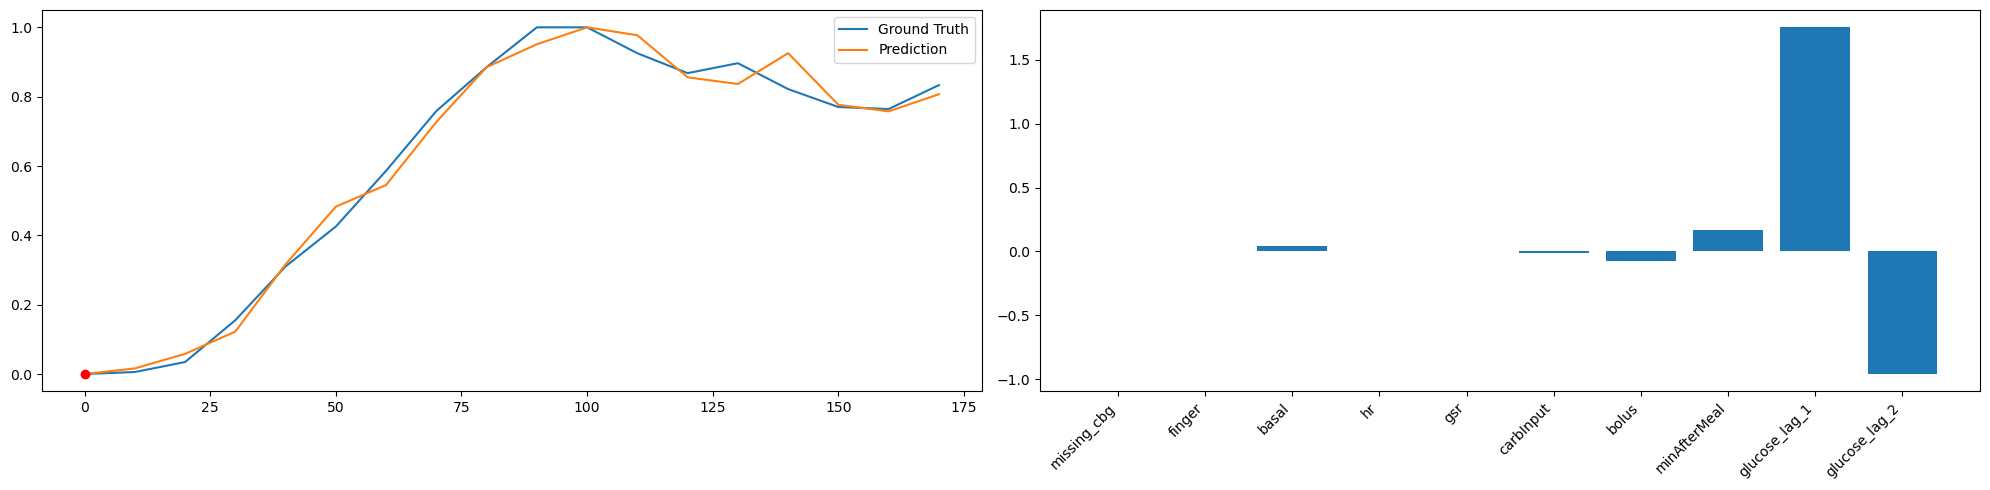

<Figure size 640x480 with 0 Axes>

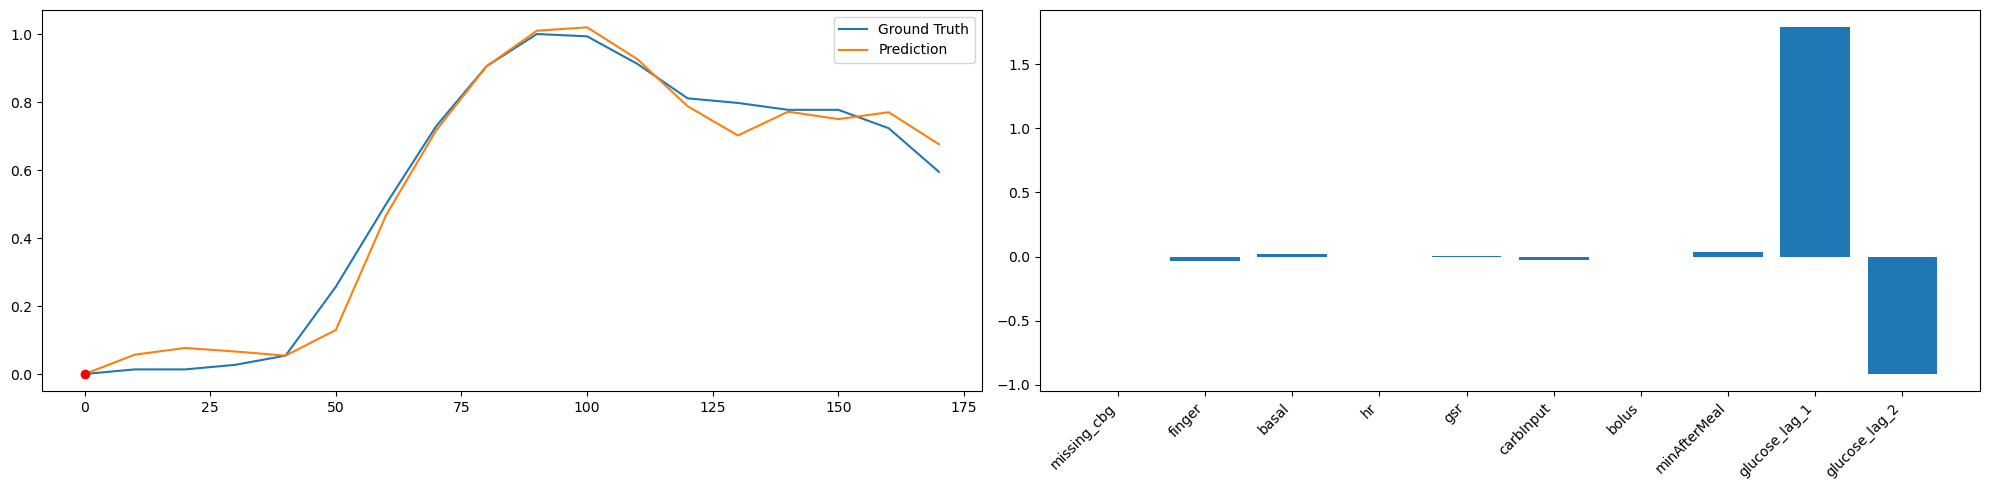

<Figure size 640x480 with 0 Axes>

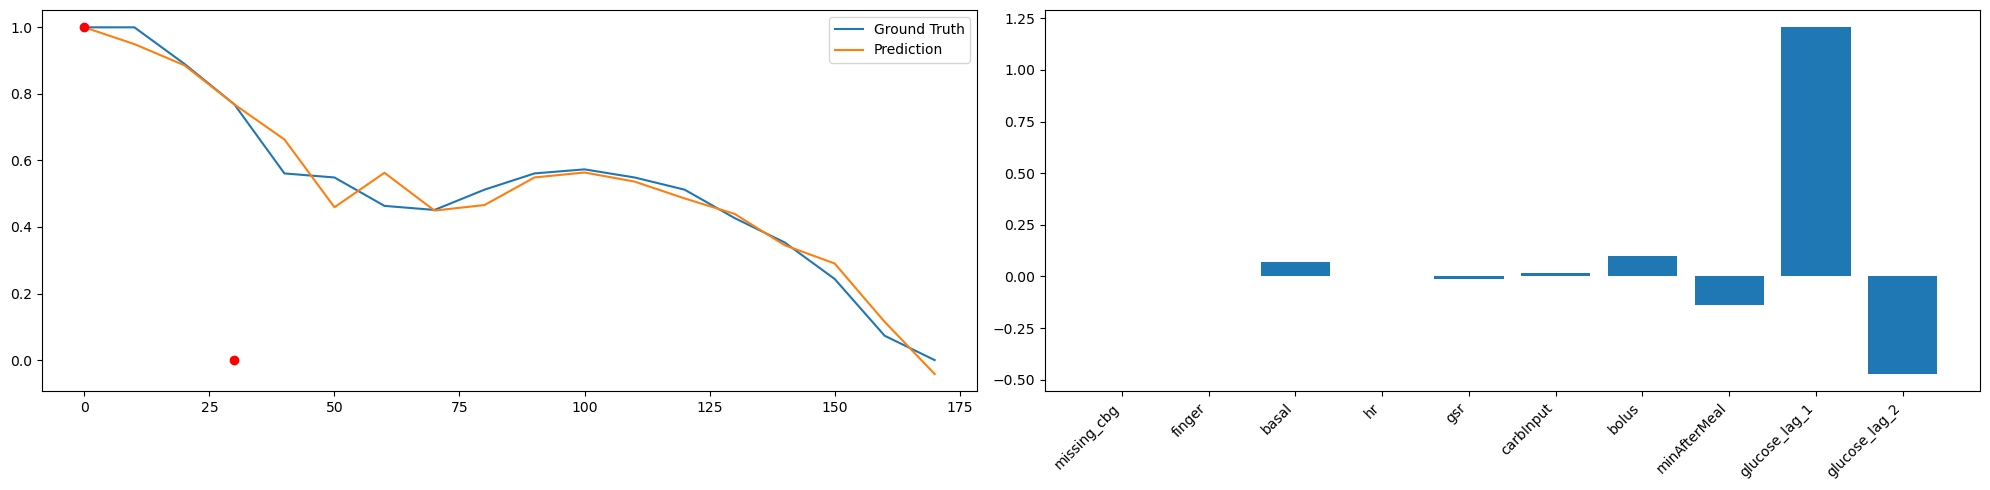

<Figure size 640x480 with 0 Axes>

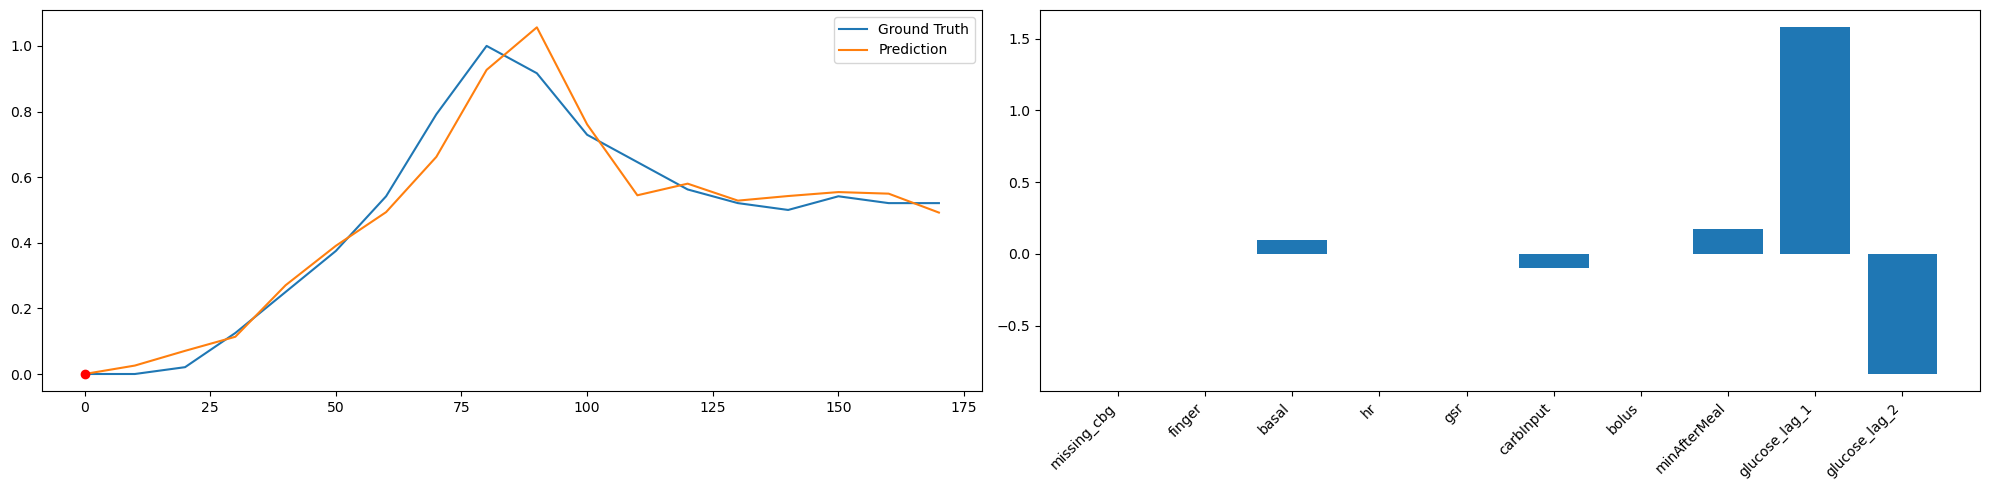

<Figure size 640x480 with 0 Axes>

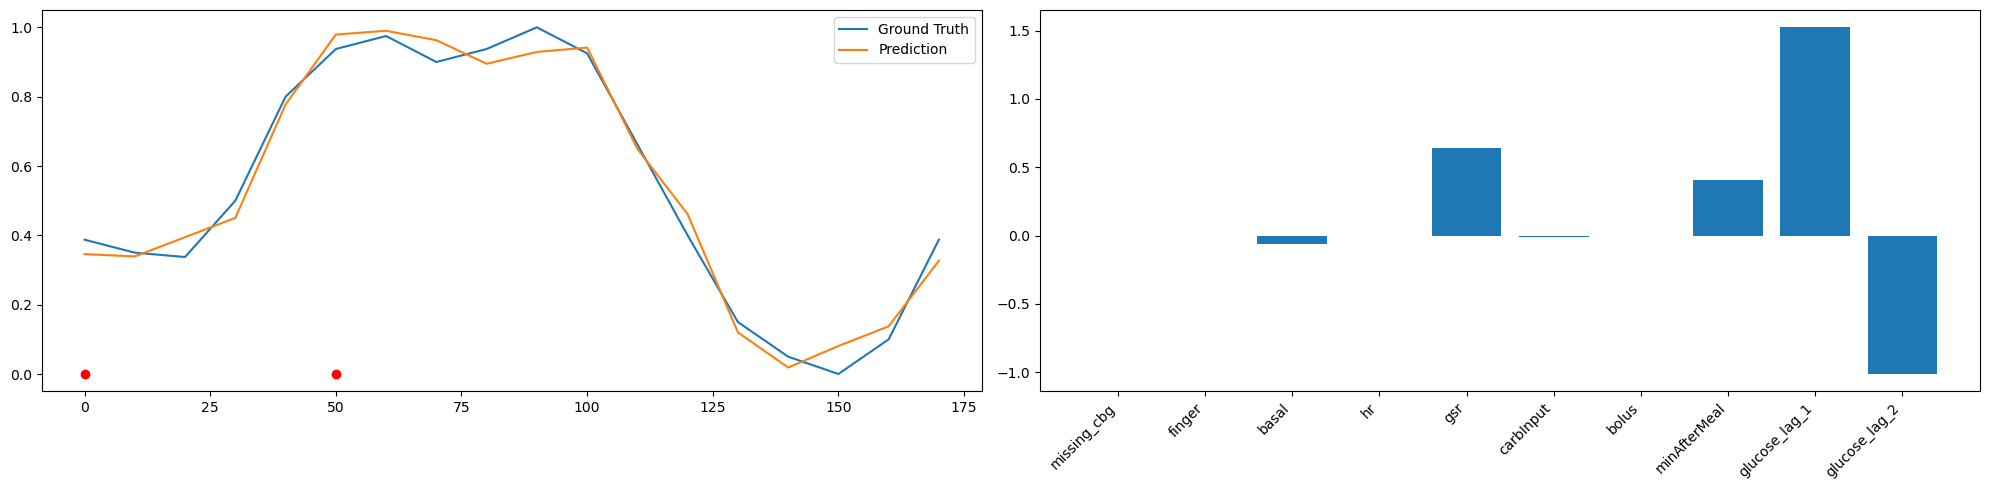

<Figure size 640x480 with 0 Axes>

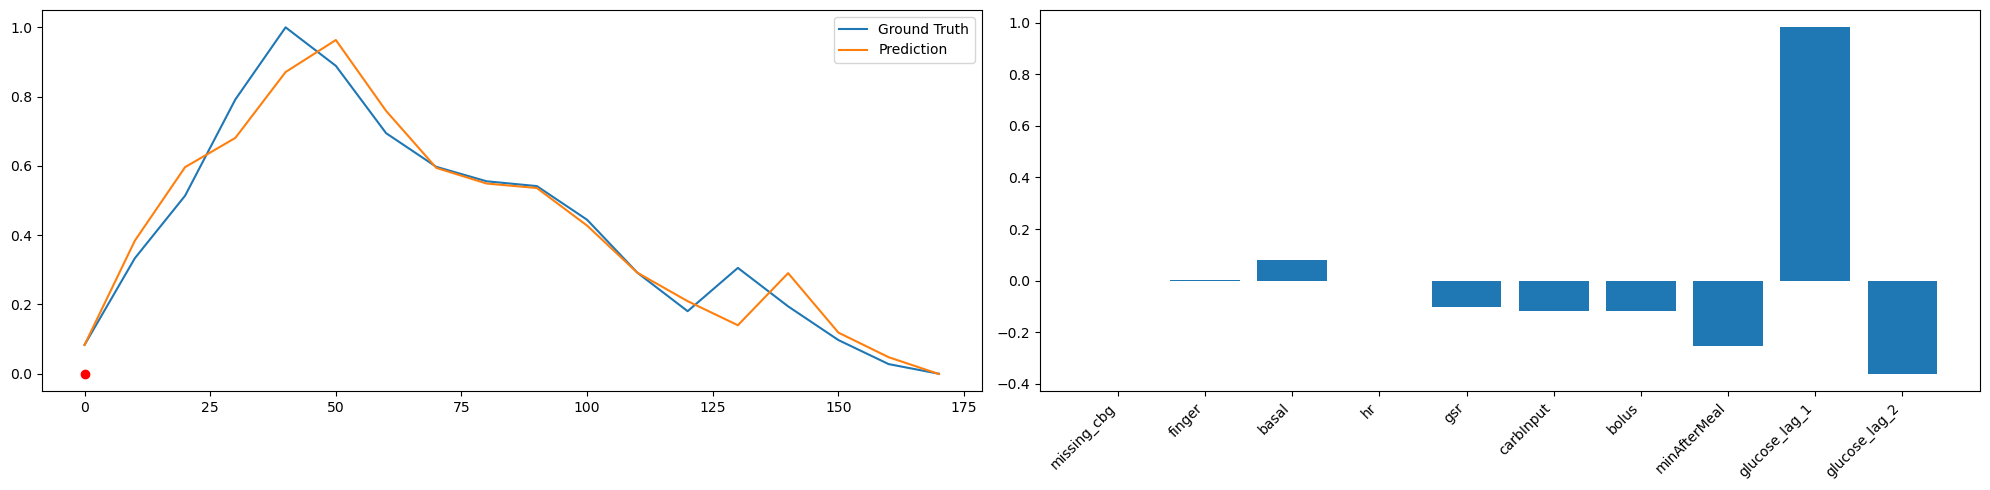

<Figure size 640x480 with 0 Axes>

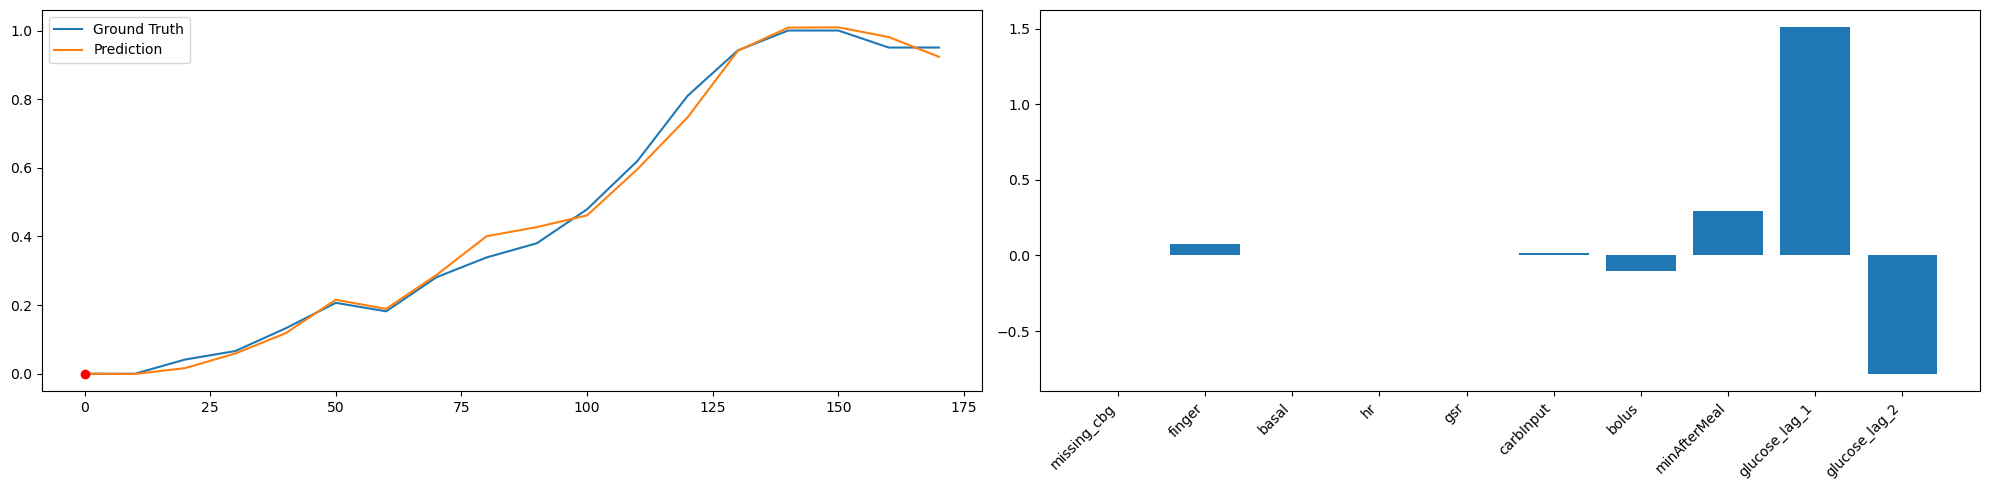

<Figure size 640x480 with 0 Axes>

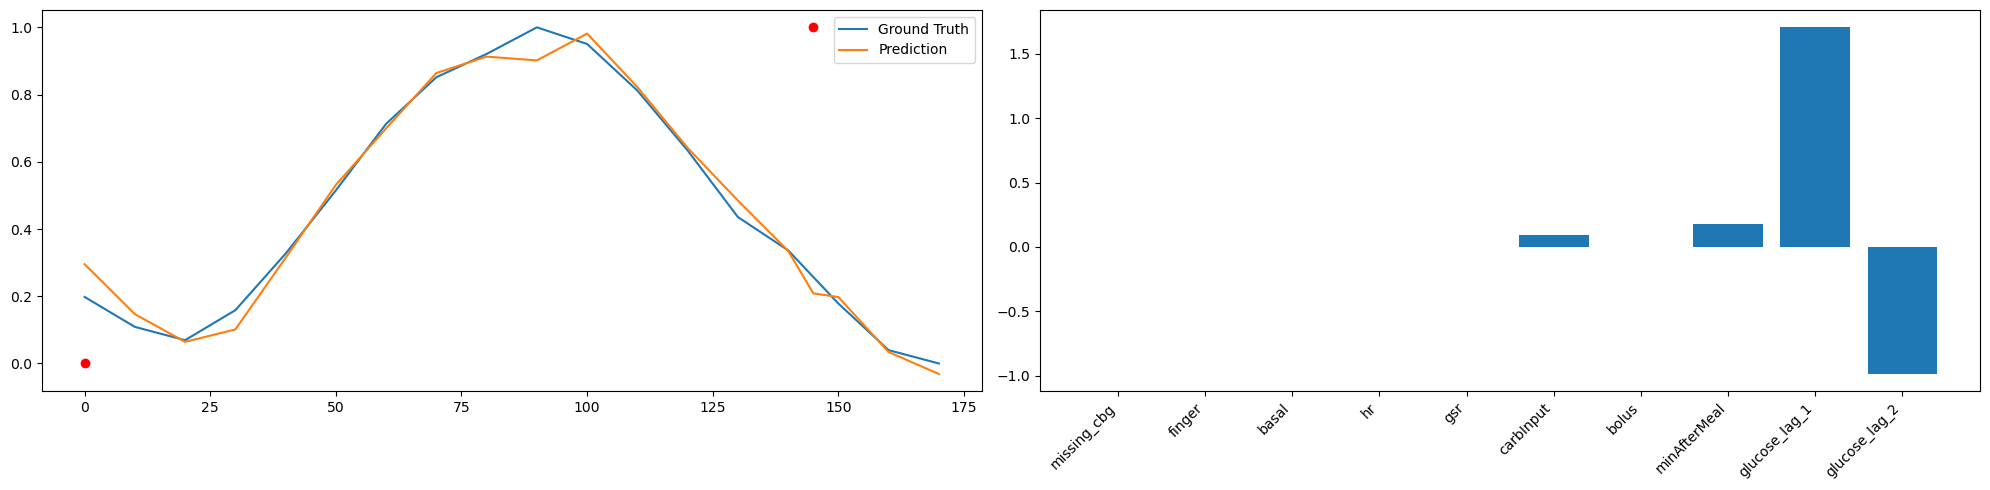

<Figure size 640x480 with 0 Axes>

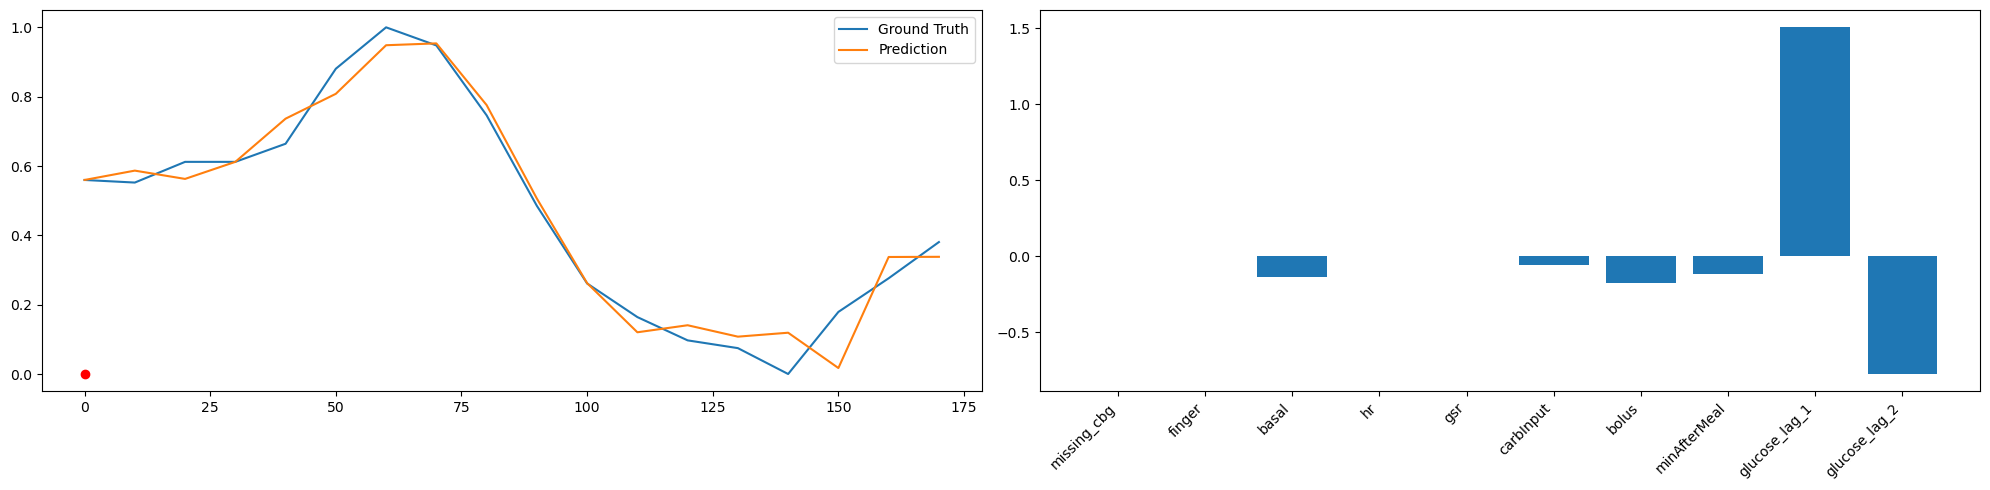

<Figure size 640x480 with 0 Axes>

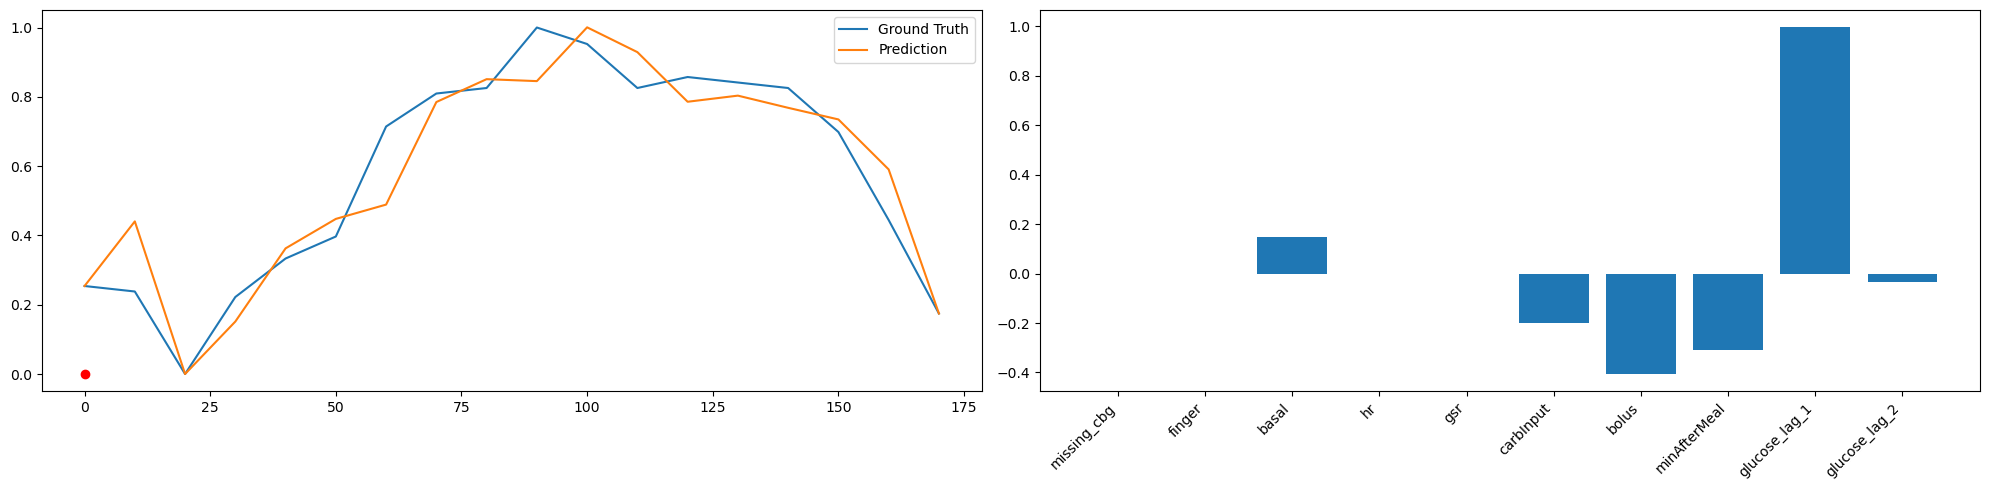

<Figure size 640x480 with 0 Axes>

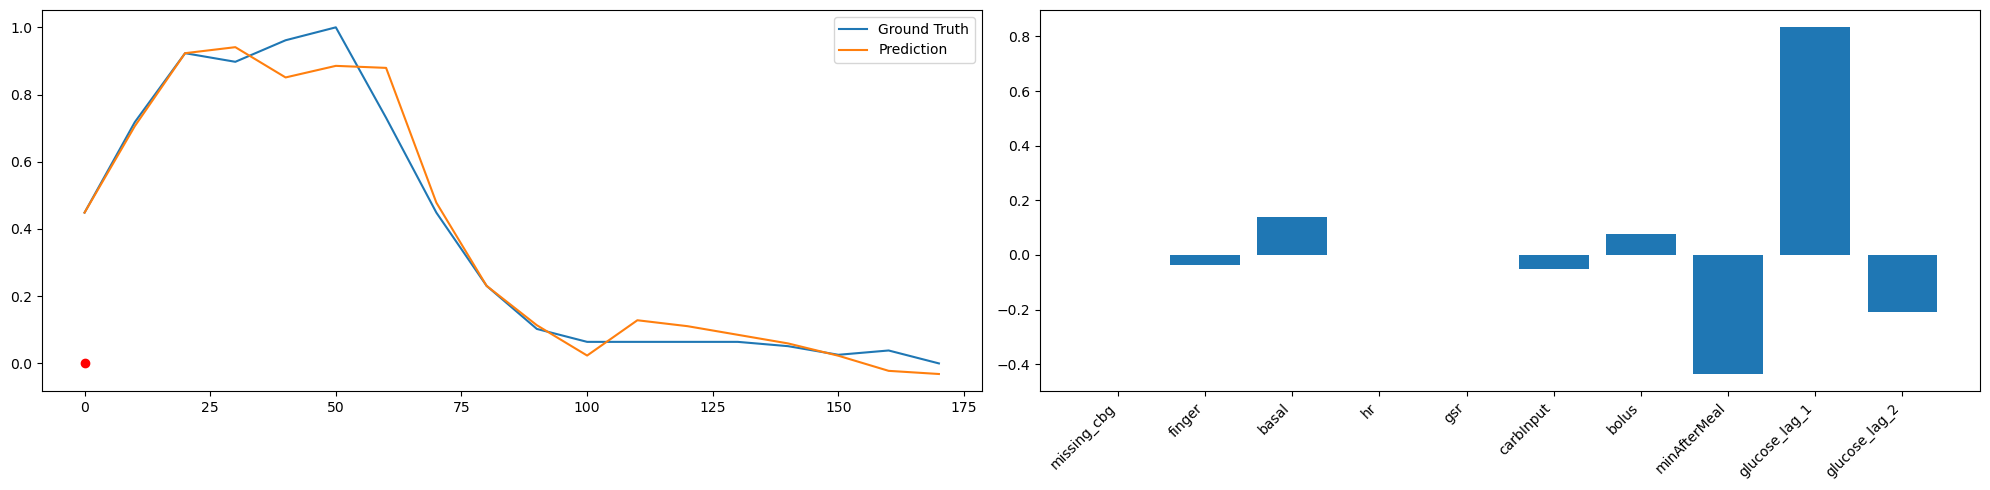

<Figure size 640x480 with 0 Axes>

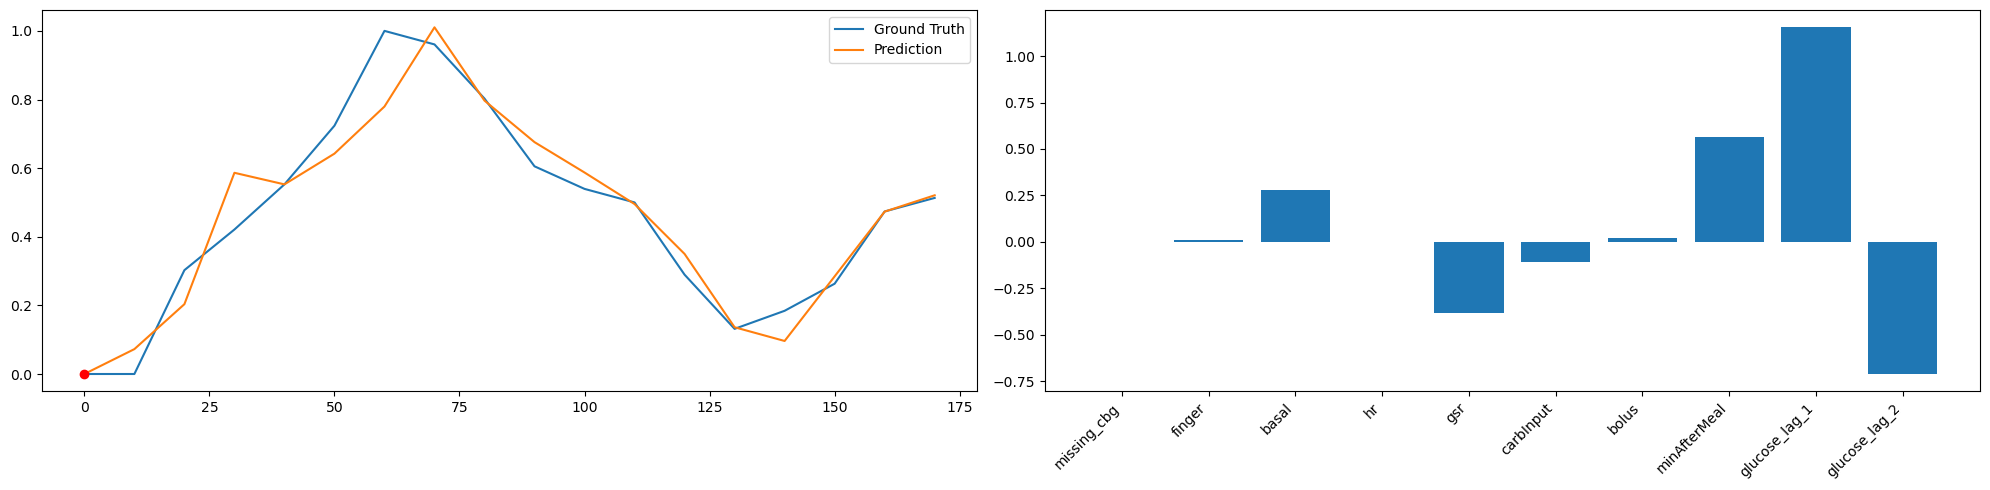

<Figure size 640x480 with 0 Axes>

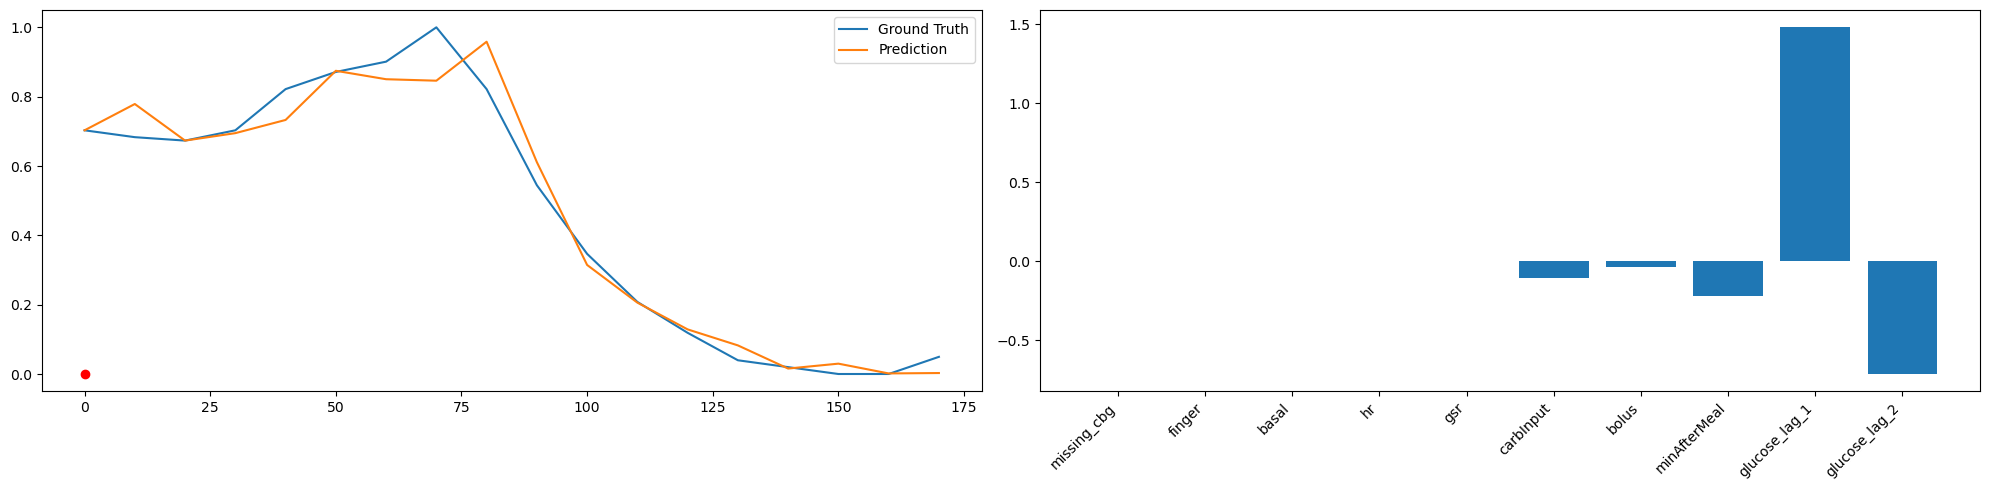

<Figure size 640x480 with 0 Axes>

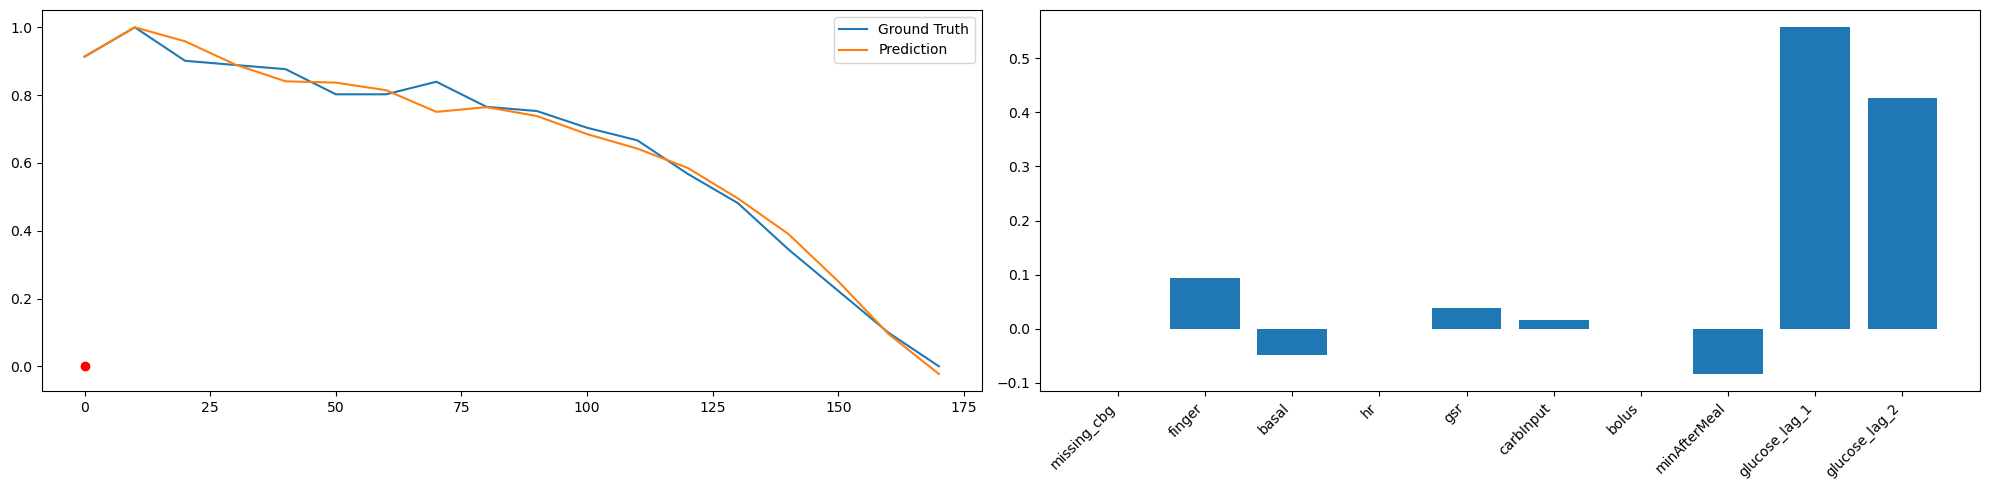

<Figure size 640x480 with 0 Axes>

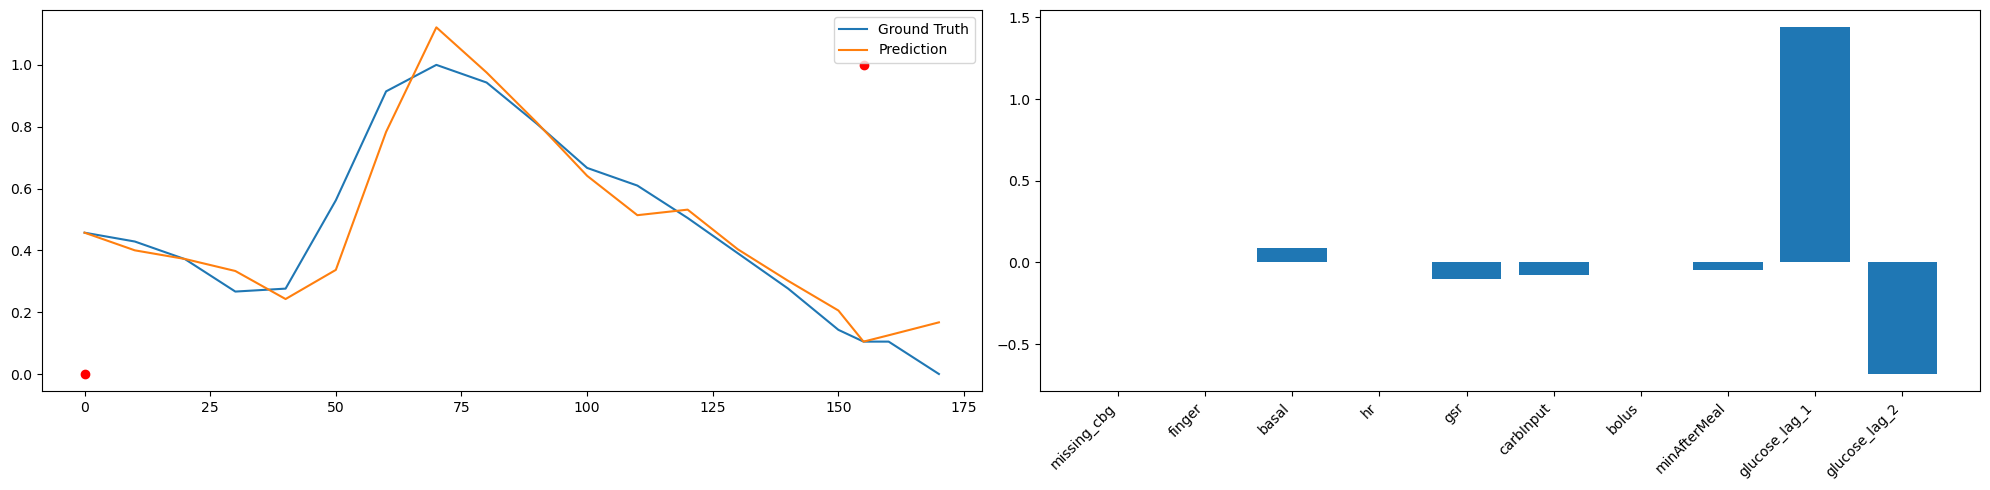

<Figure size 640x480 with 0 Axes>

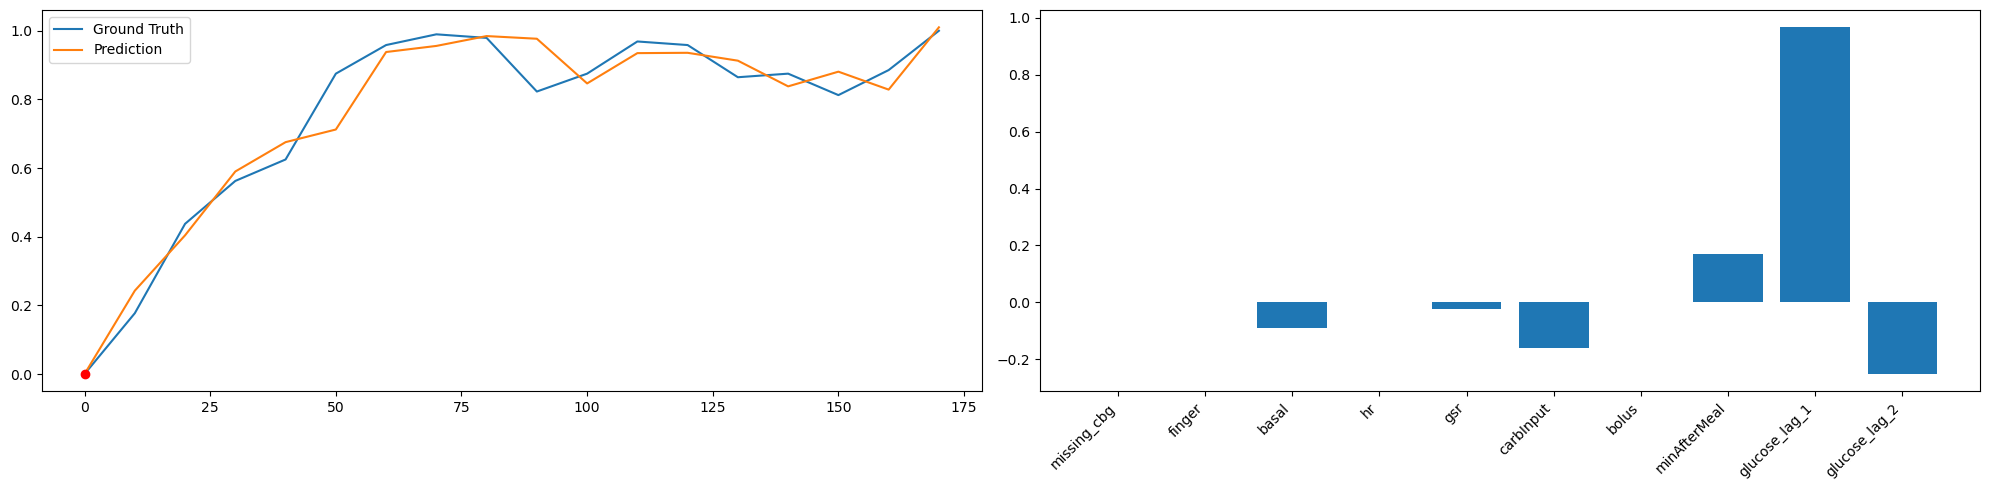

<Figure size 640x480 with 0 Axes>

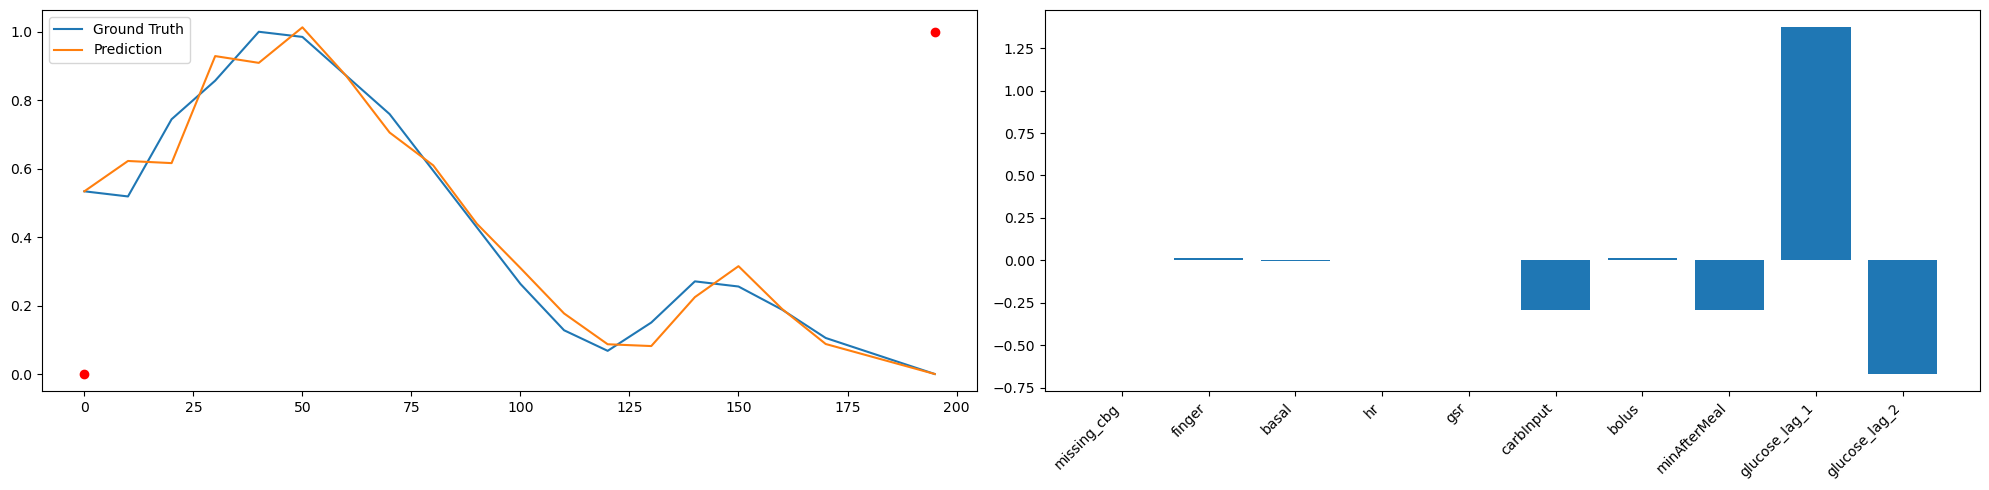

<Figure size 640x480 with 0 Axes>

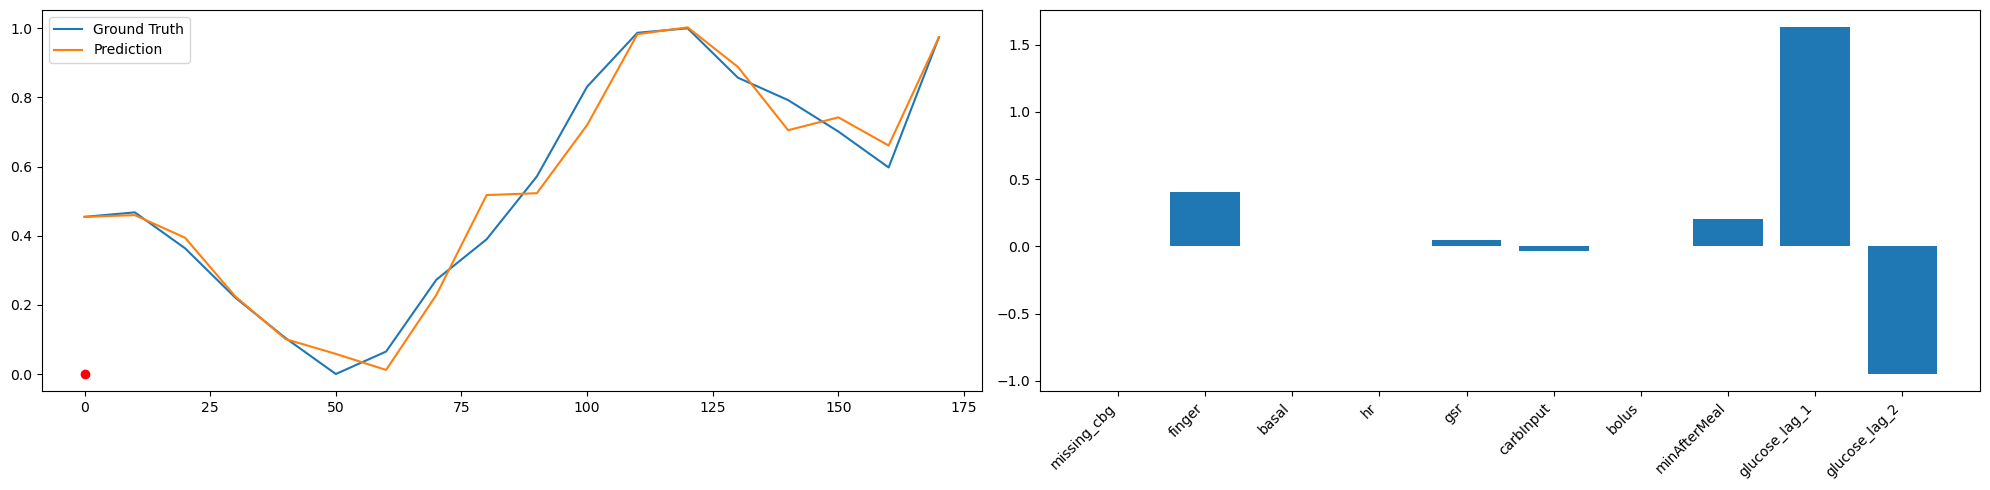

<Figure size 640x480 with 0 Axes>

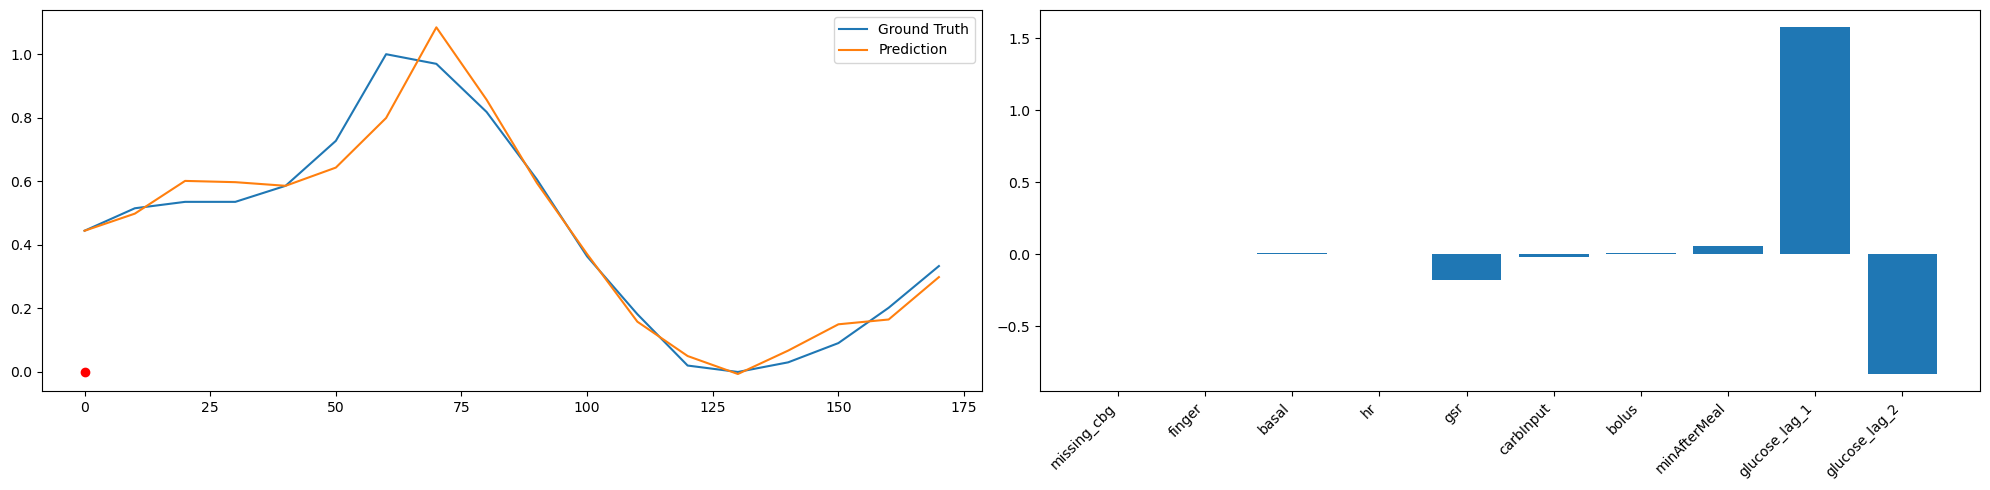

<Figure size 640x480 with 0 Axes>

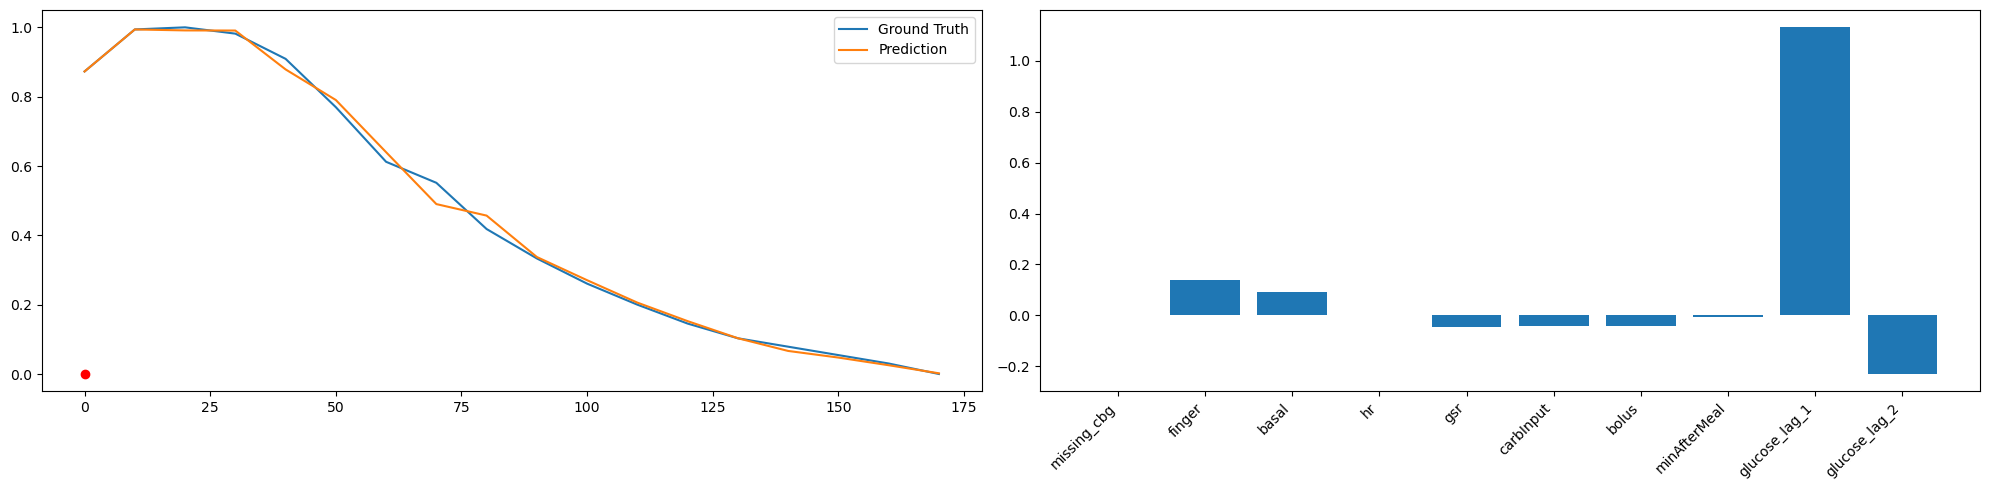

<Figure size 640x480 with 0 Axes>

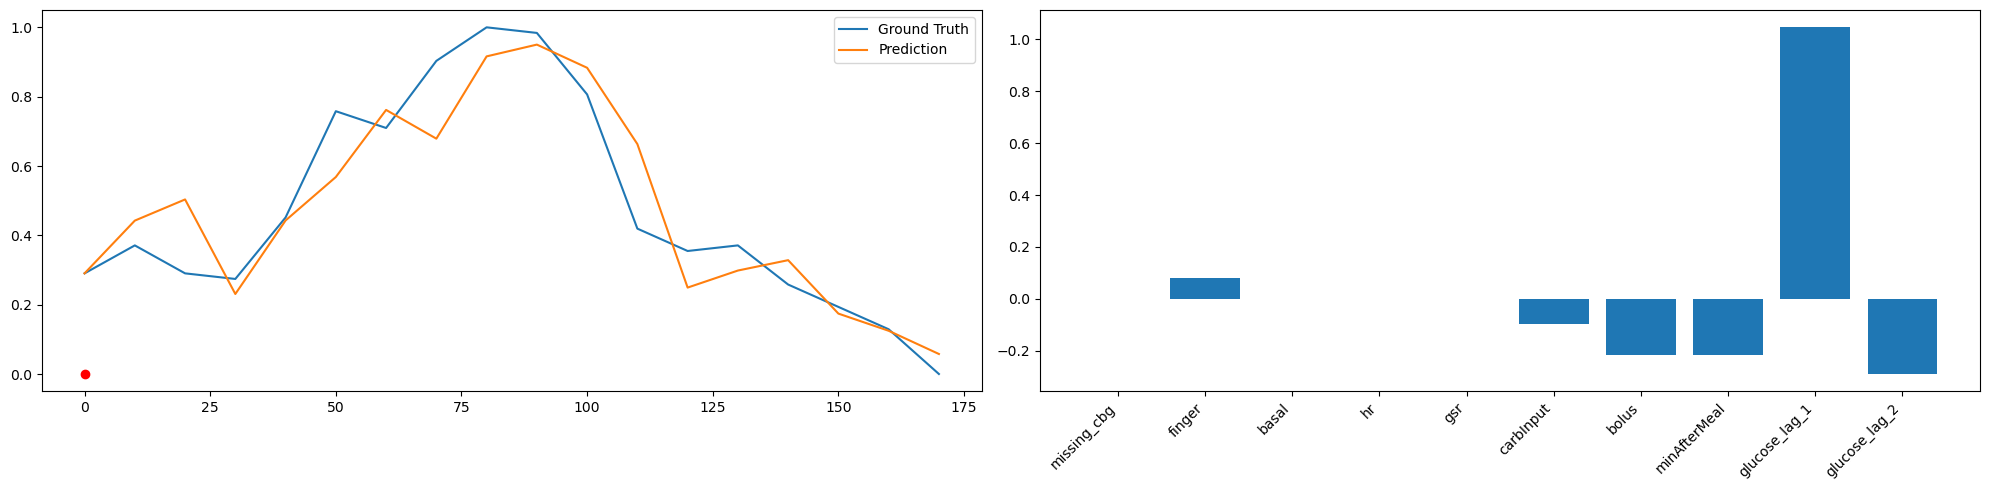

<Figure size 640x480 with 0 Axes>

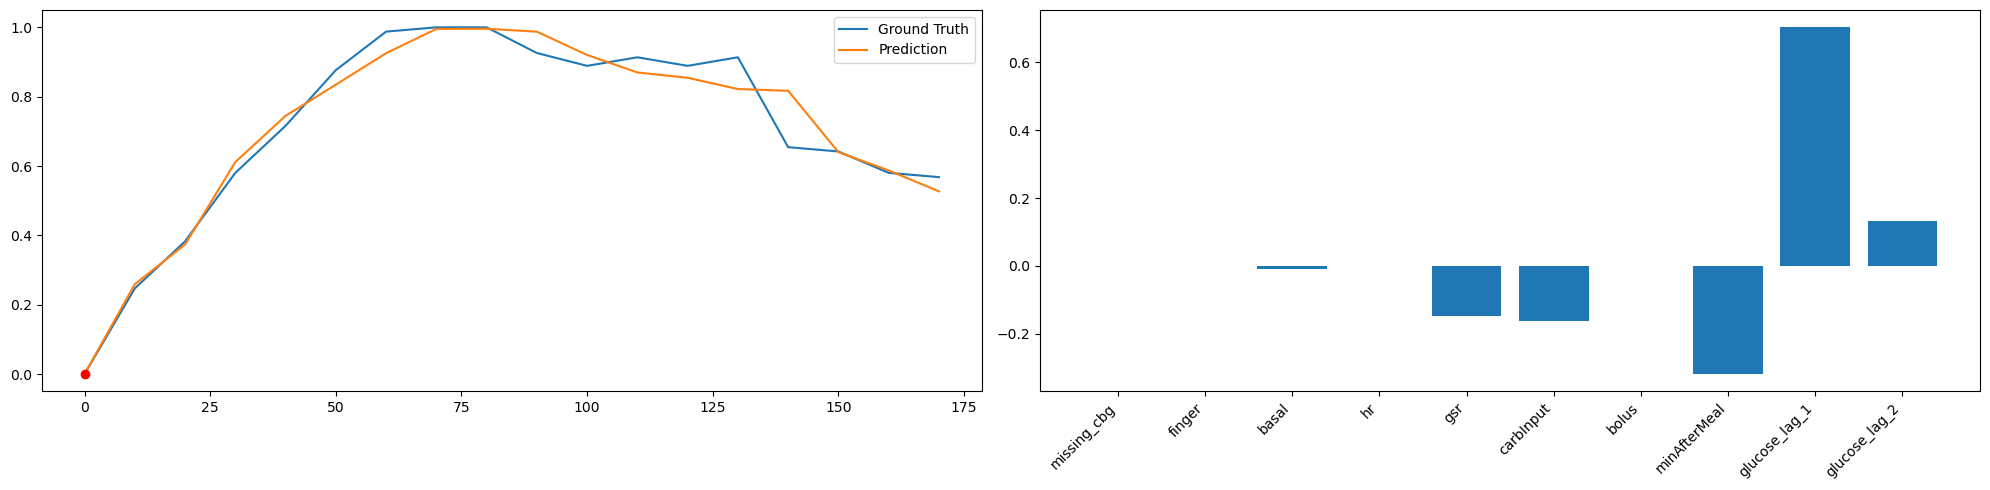

<Figure size 640x480 with 0 Axes>

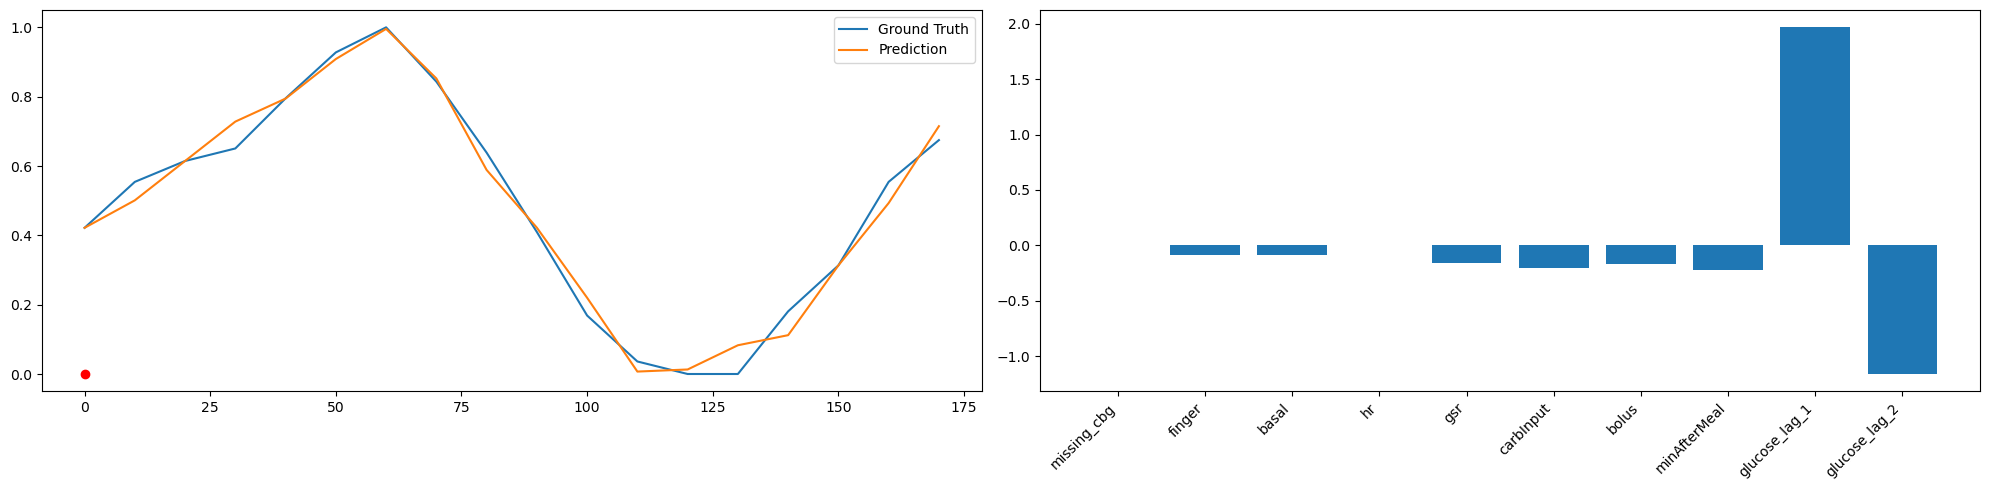

<Figure size 640x480 with 0 Axes>

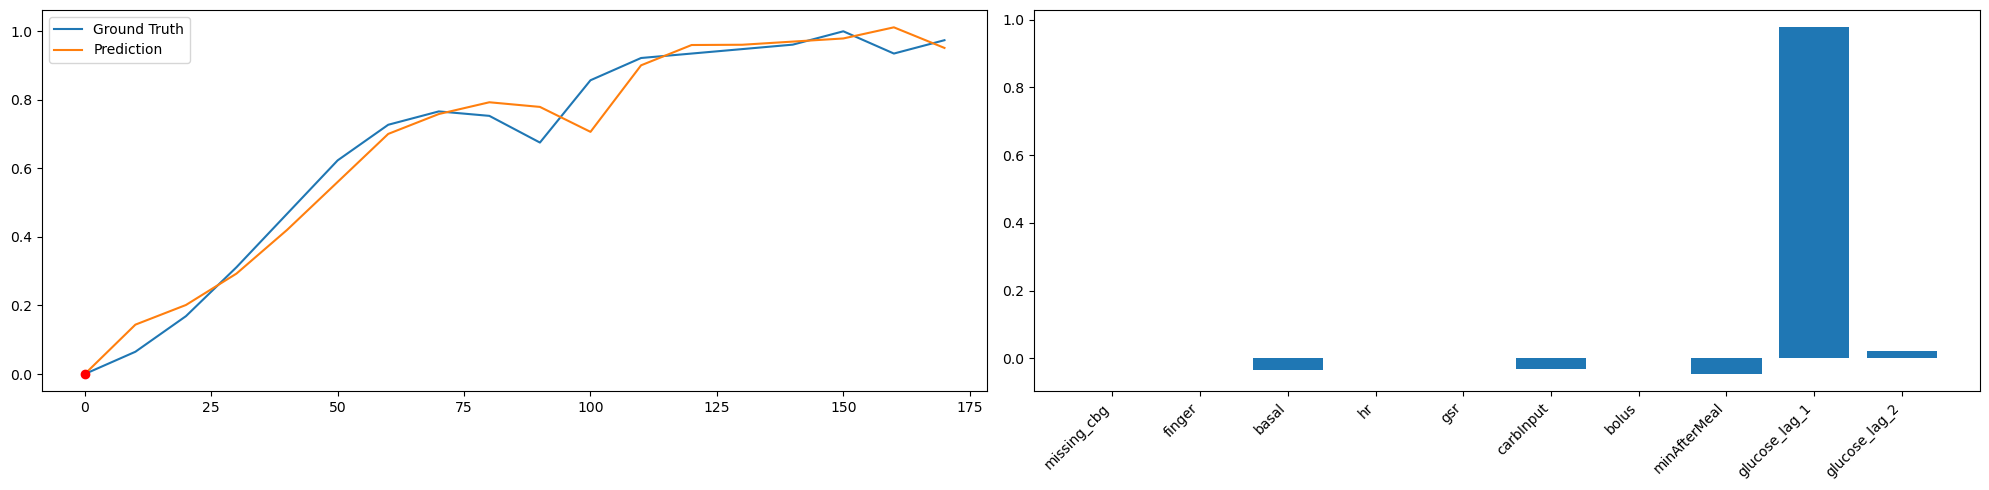

<Figure size 640x480 with 0 Axes>

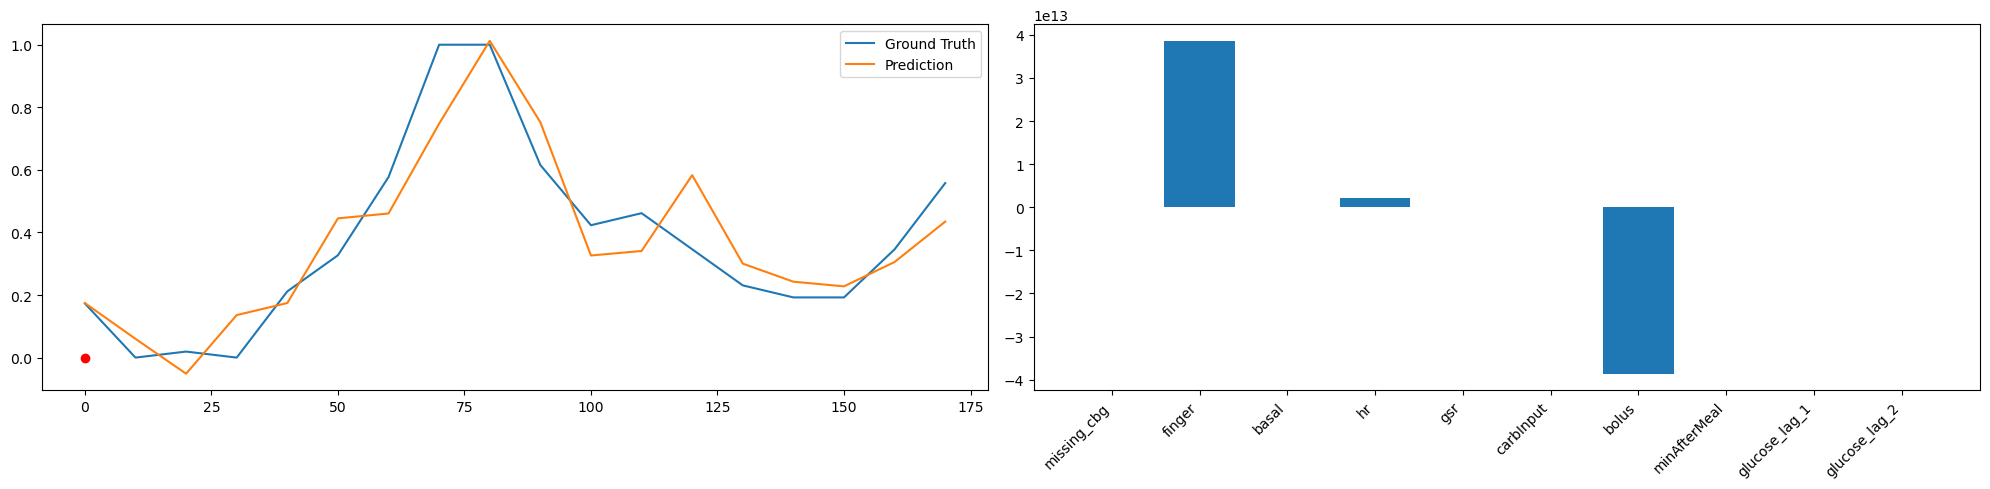

<Figure size 640x480 with 0 Axes>

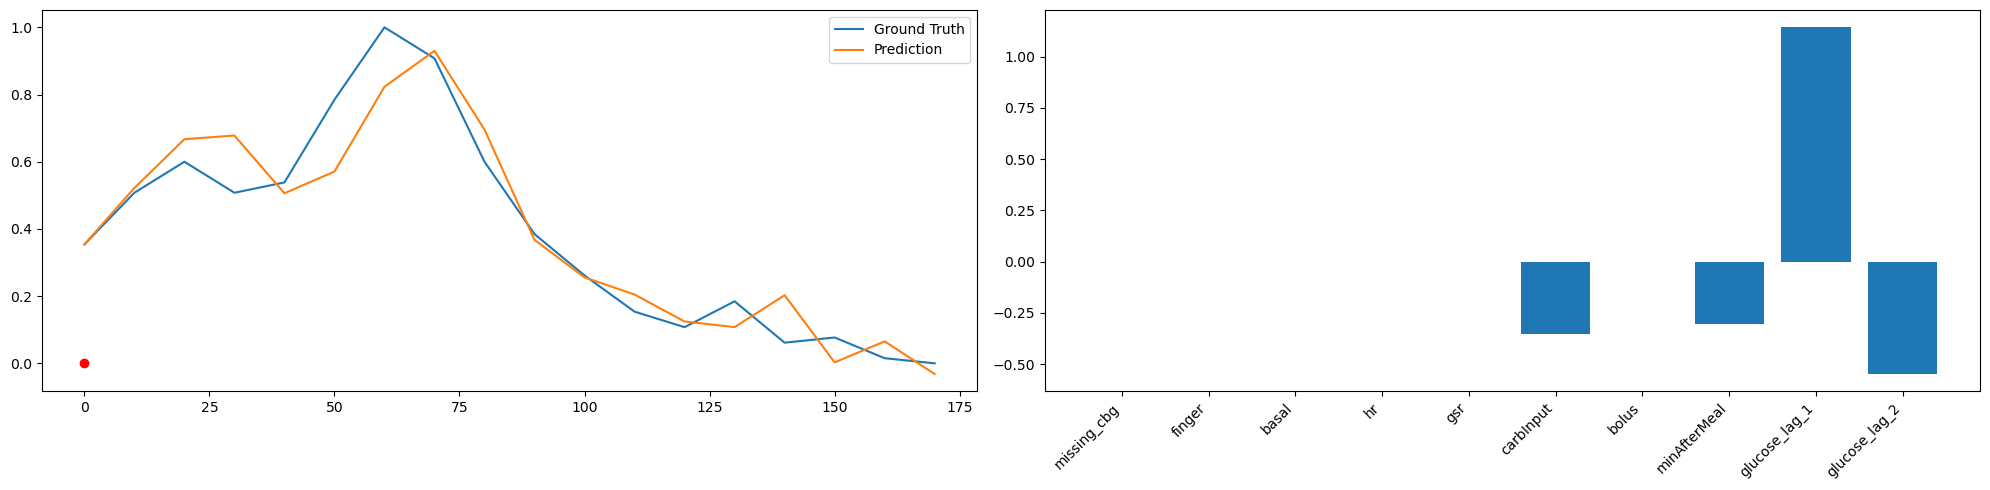

<Figure size 640x480 with 0 Axes>

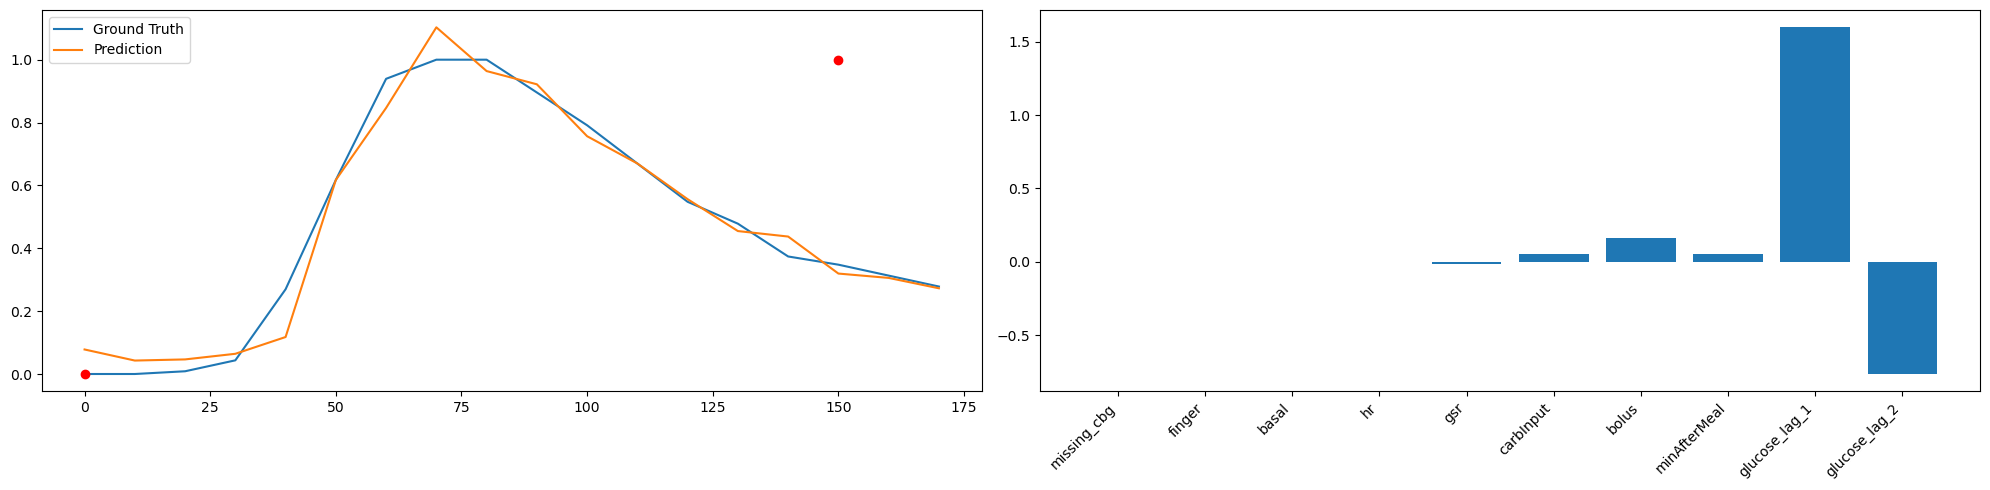

<Figure size 640x480 with 0 Axes>

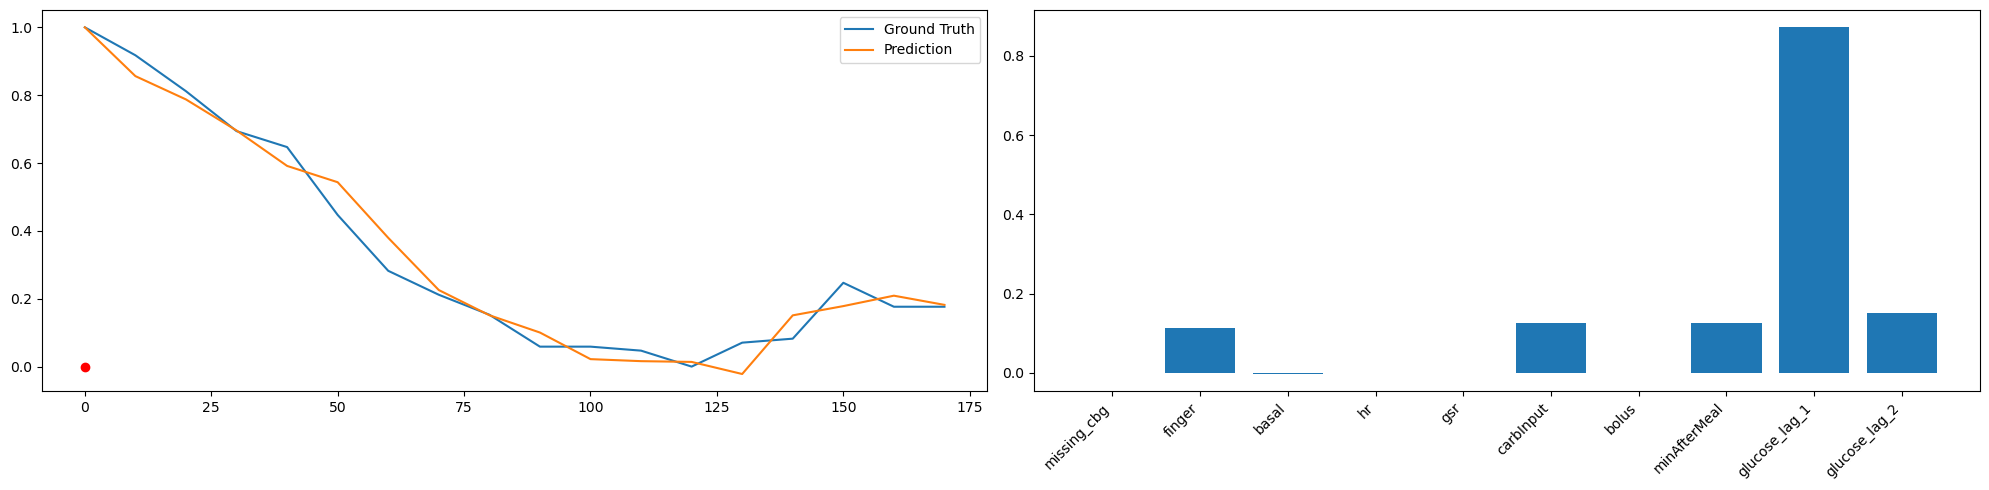

<Figure size 640x480 with 0 Axes>

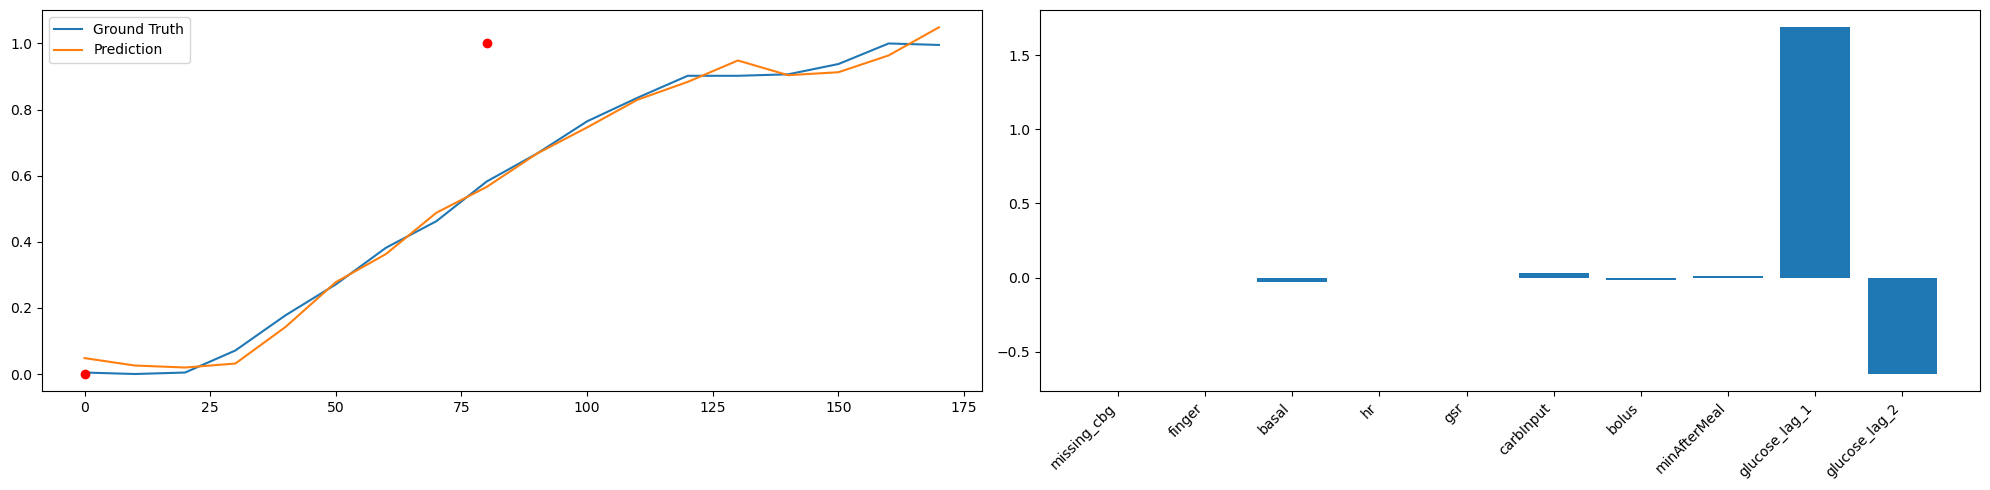

<Figure size 640x480 with 0 Axes>

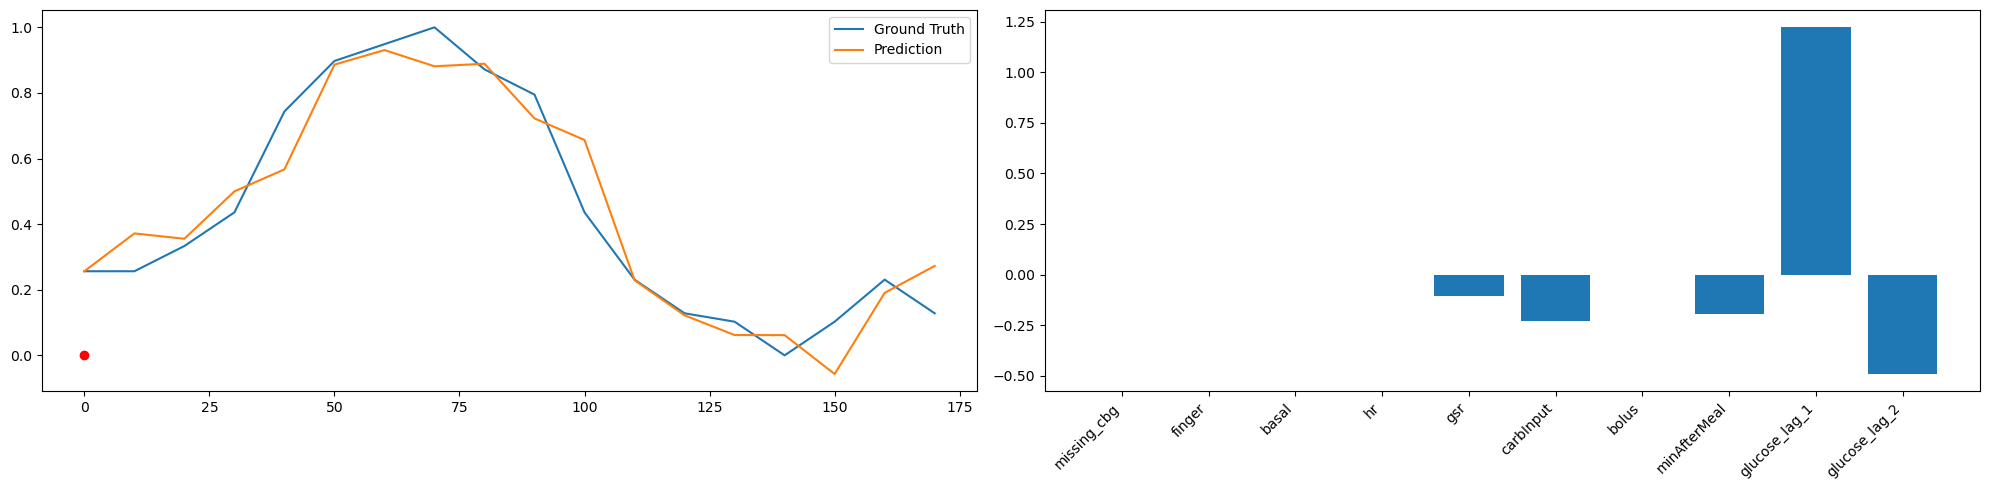

In [318]:
coef = []
model = LinearRegression()
for data in X_train:
    plt.figure()
    coef.append(train_model(data, model))


In [319]:
averageCoef = 0
for x in coef:
    averageCoef += x

averageCoef / len(coef)

array([ 0.00000000e+00,  9.65175077e+11,  1.91034769e-02,  5.49131097e+10,
       -2.57275364e-02, -5.11852537e-02, -9.65175077e+11, -2.94824767e-02,
        1.29354579e+00, -5.50842020e-01])

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_55081/2978319518.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

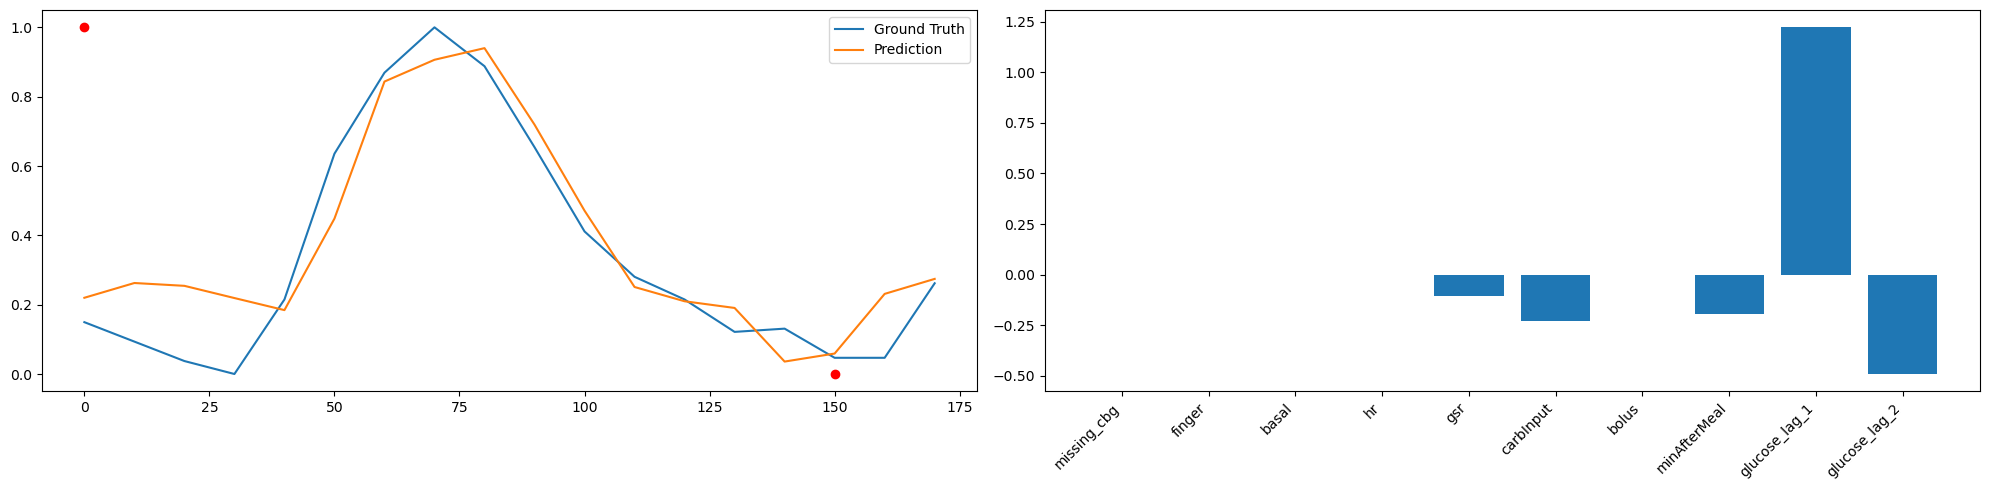

<Figure size 640x480 with 0 Axes>

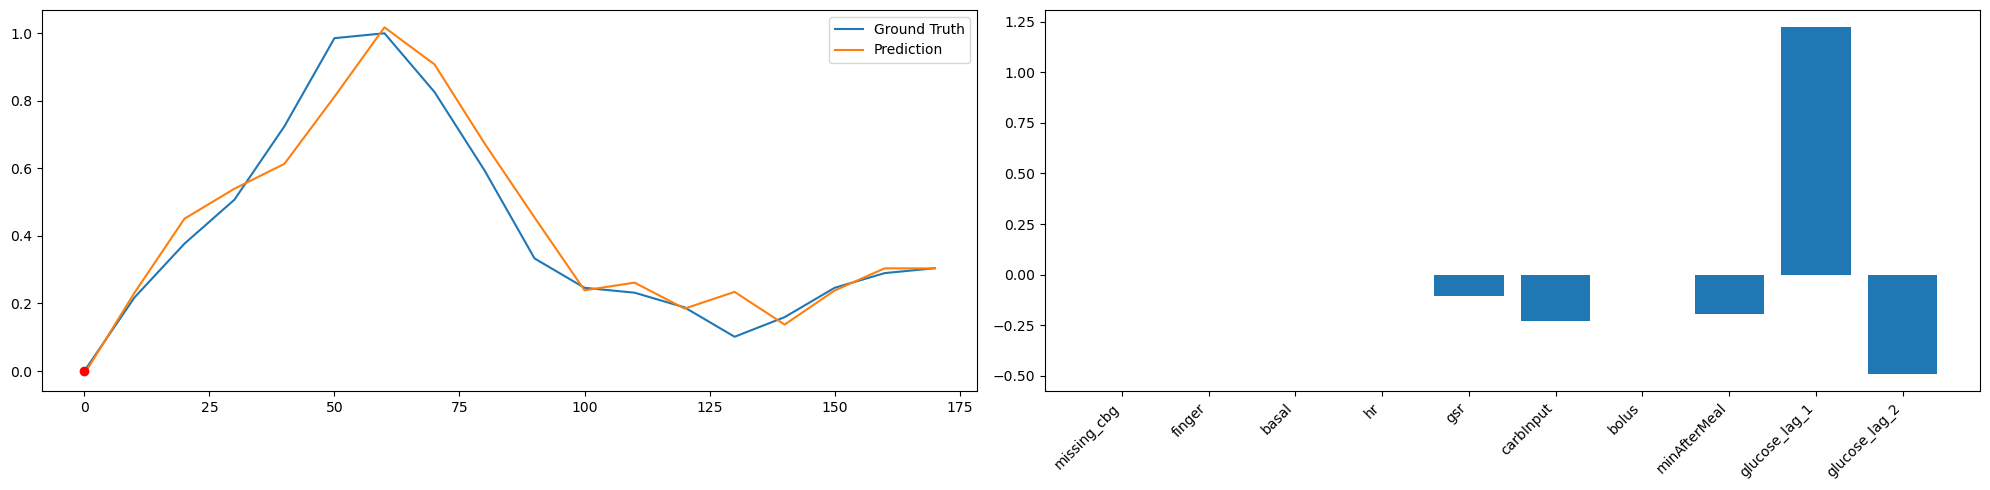

<Figure size 640x480 with 0 Axes>

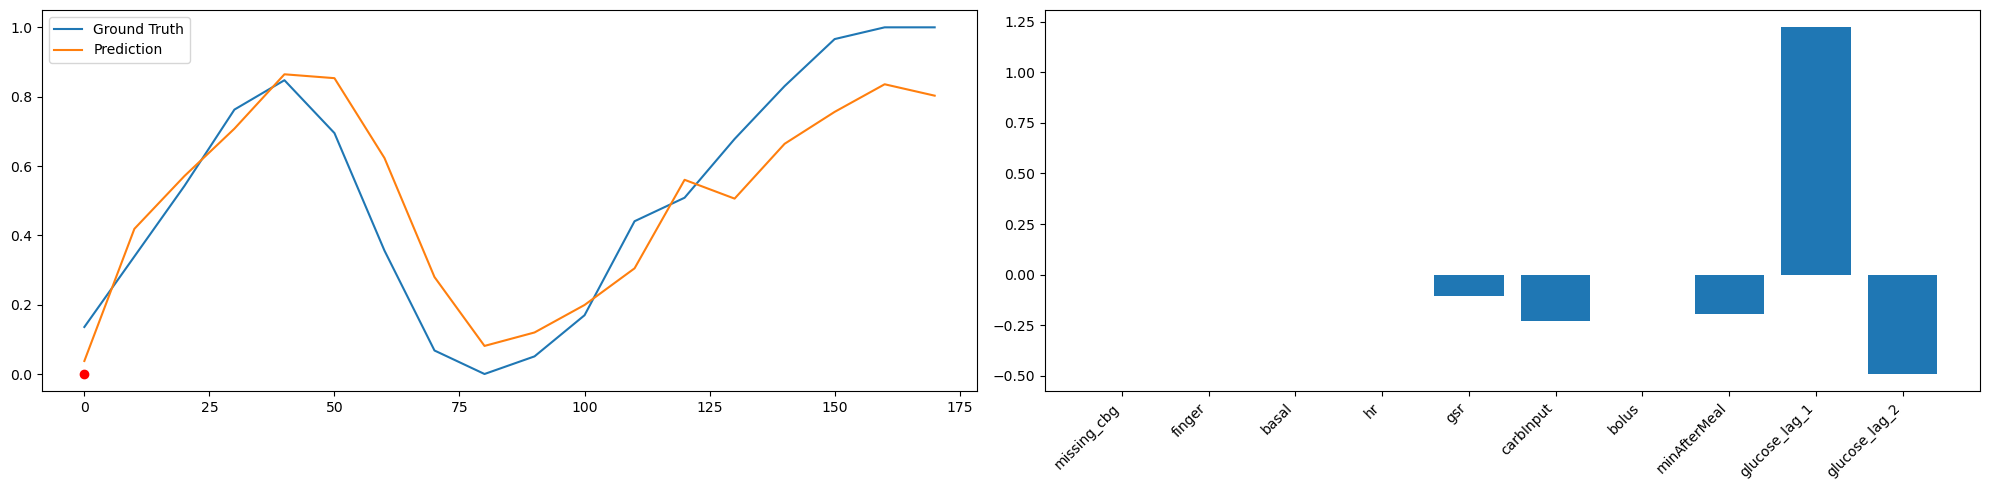

<Figure size 640x480 with 0 Axes>

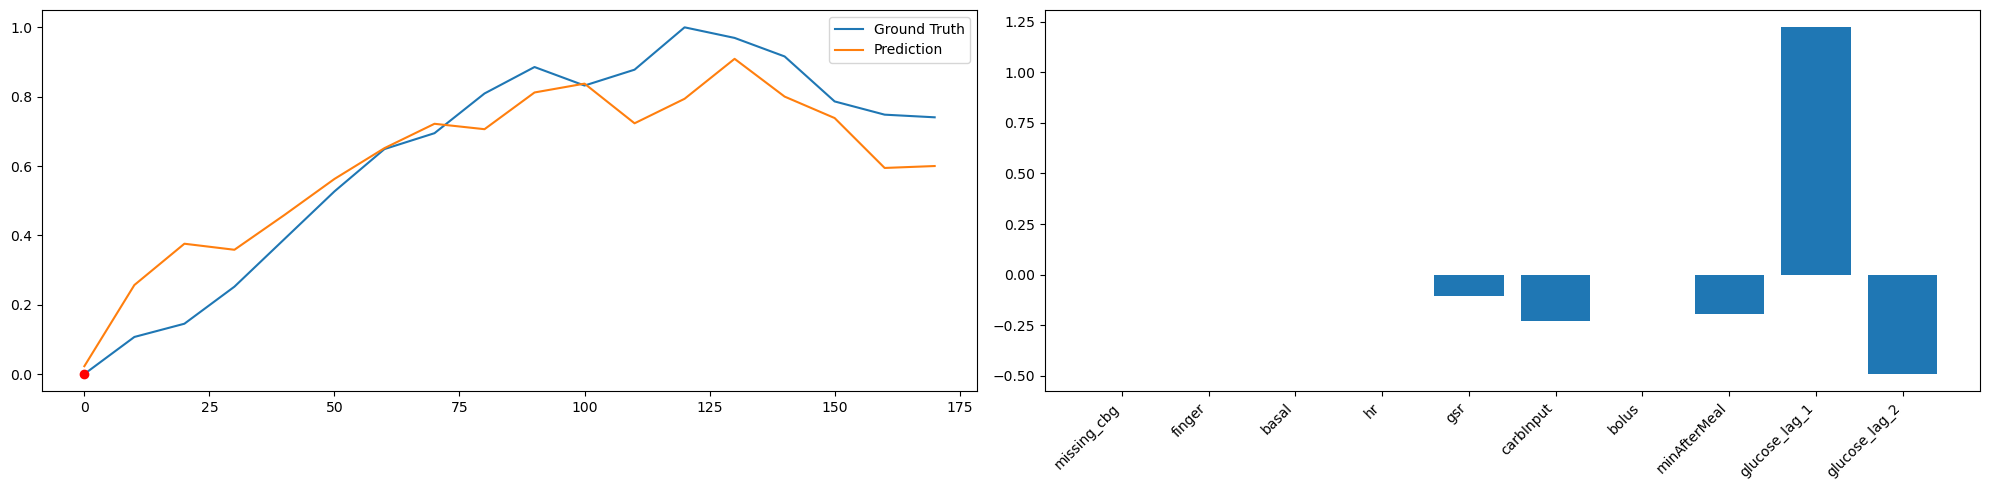

<Figure size 640x480 with 0 Axes>

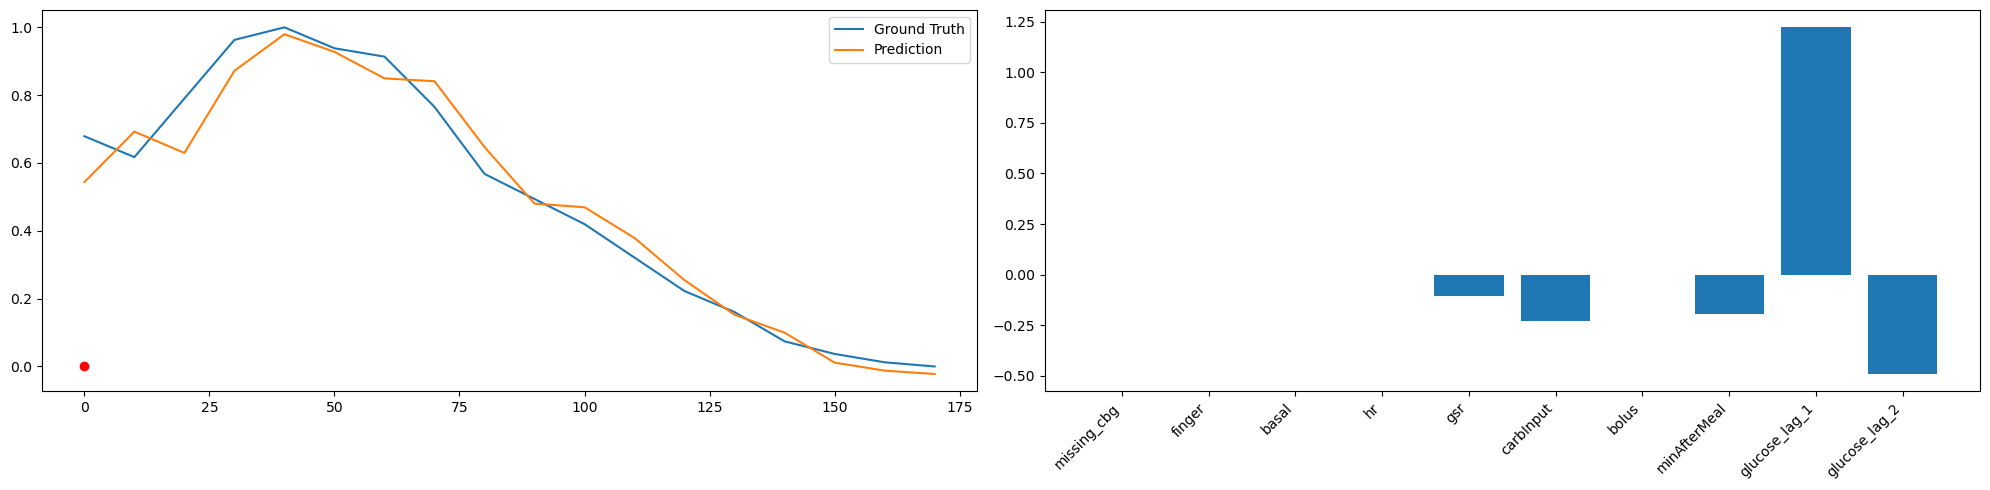

<Figure size 640x480 with 0 Axes>

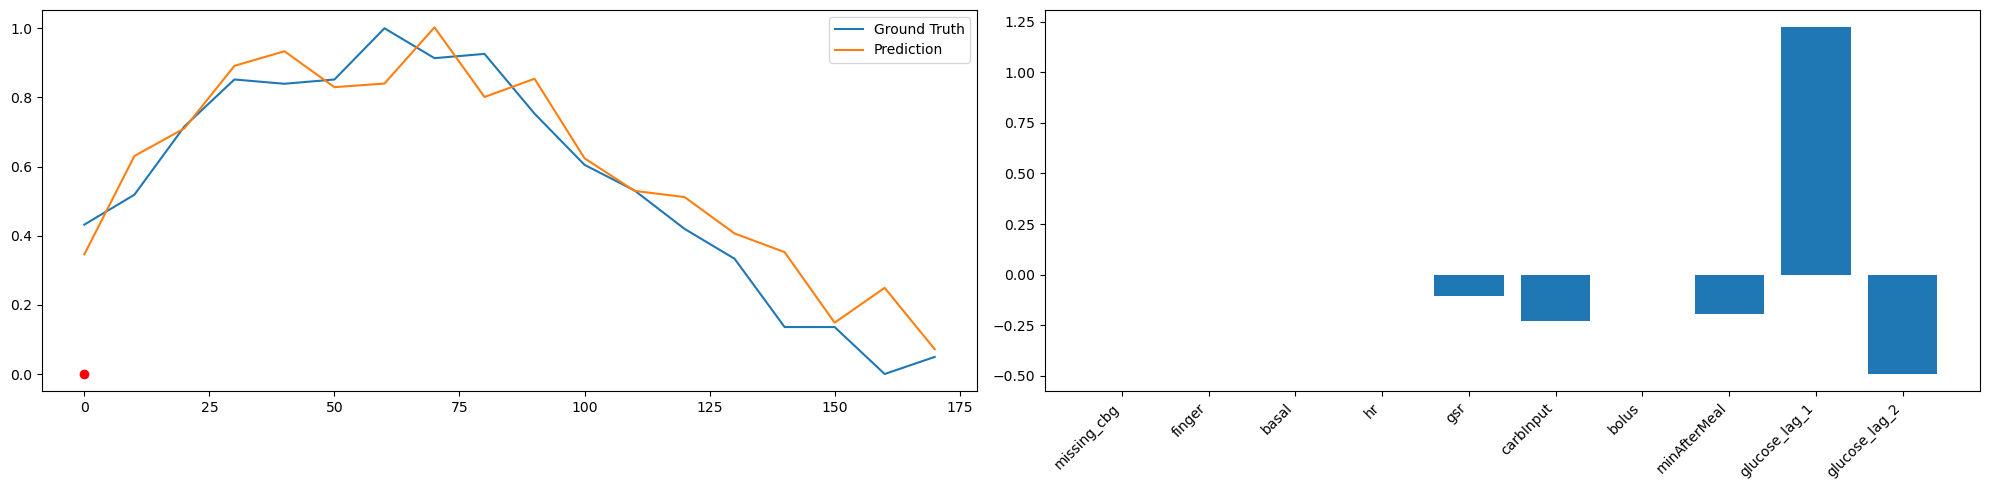

<Figure size 640x480 with 0 Axes>

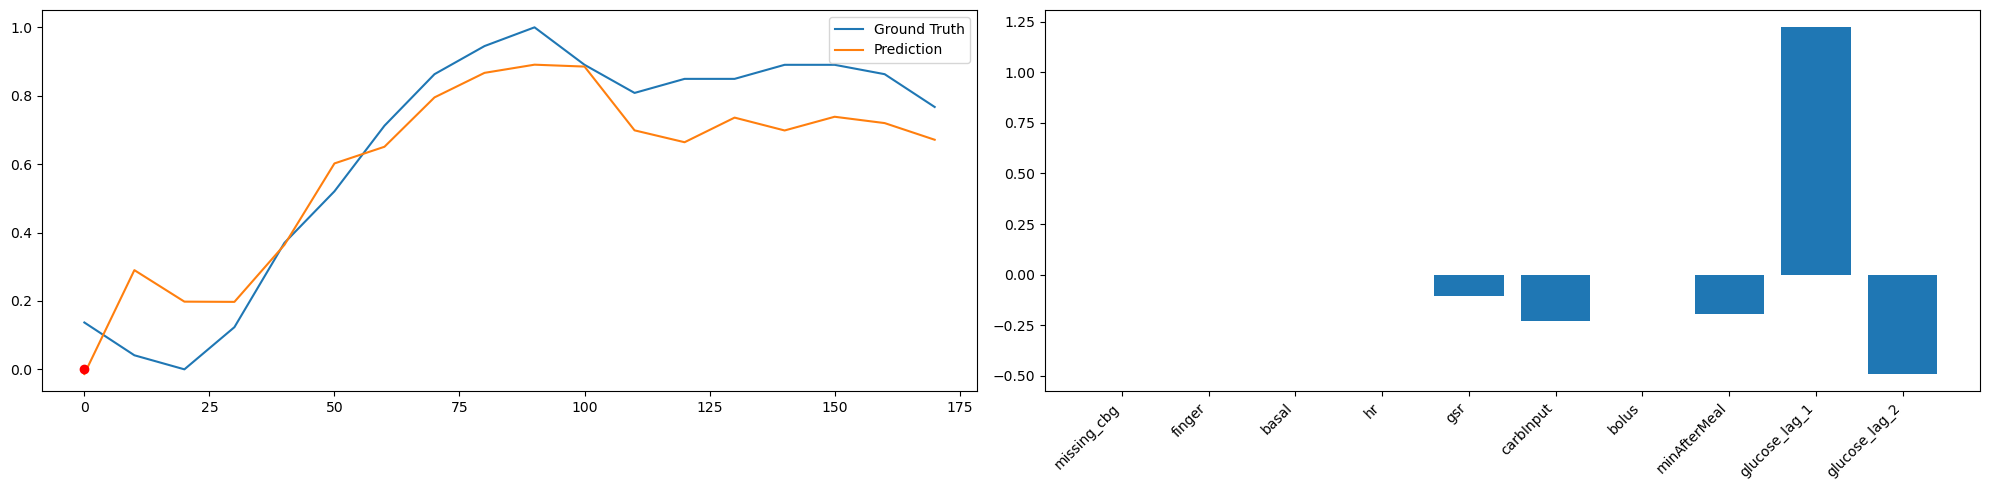

<Figure size 640x480 with 0 Axes>

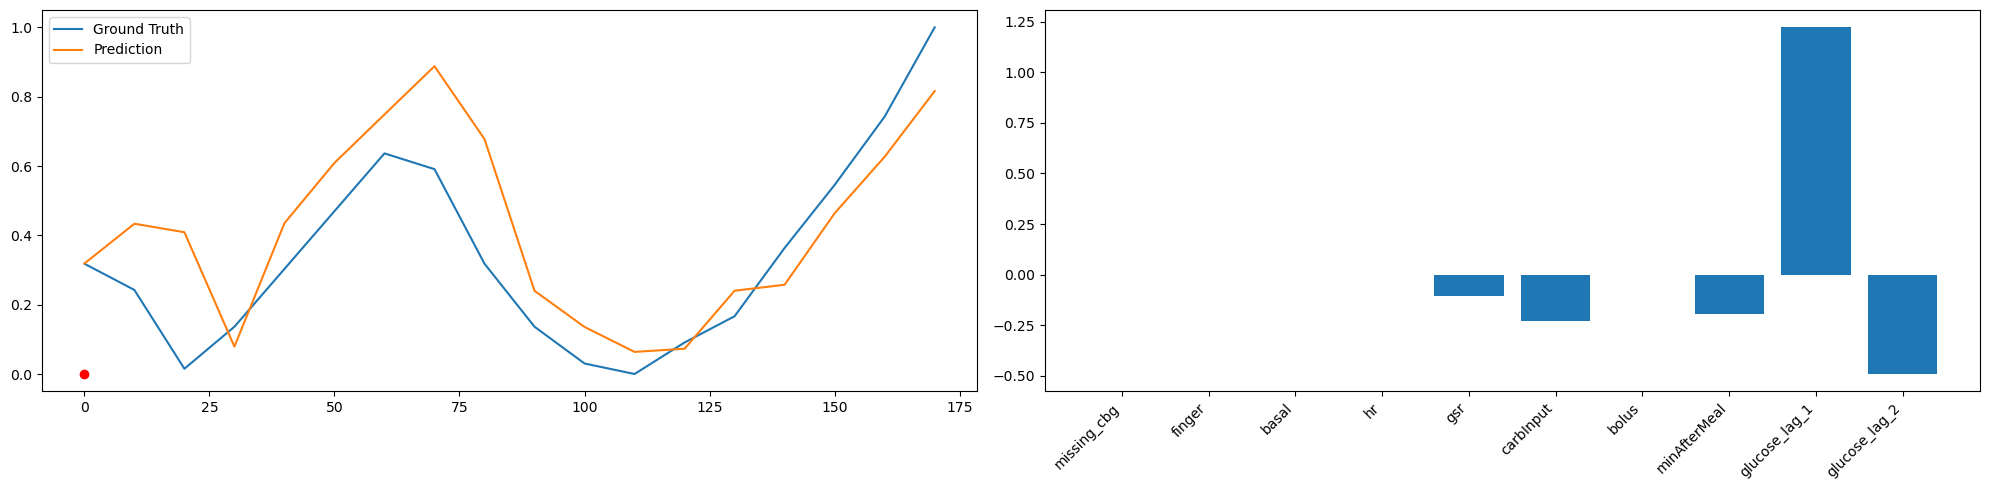

<Figure size 640x480 with 0 Axes>

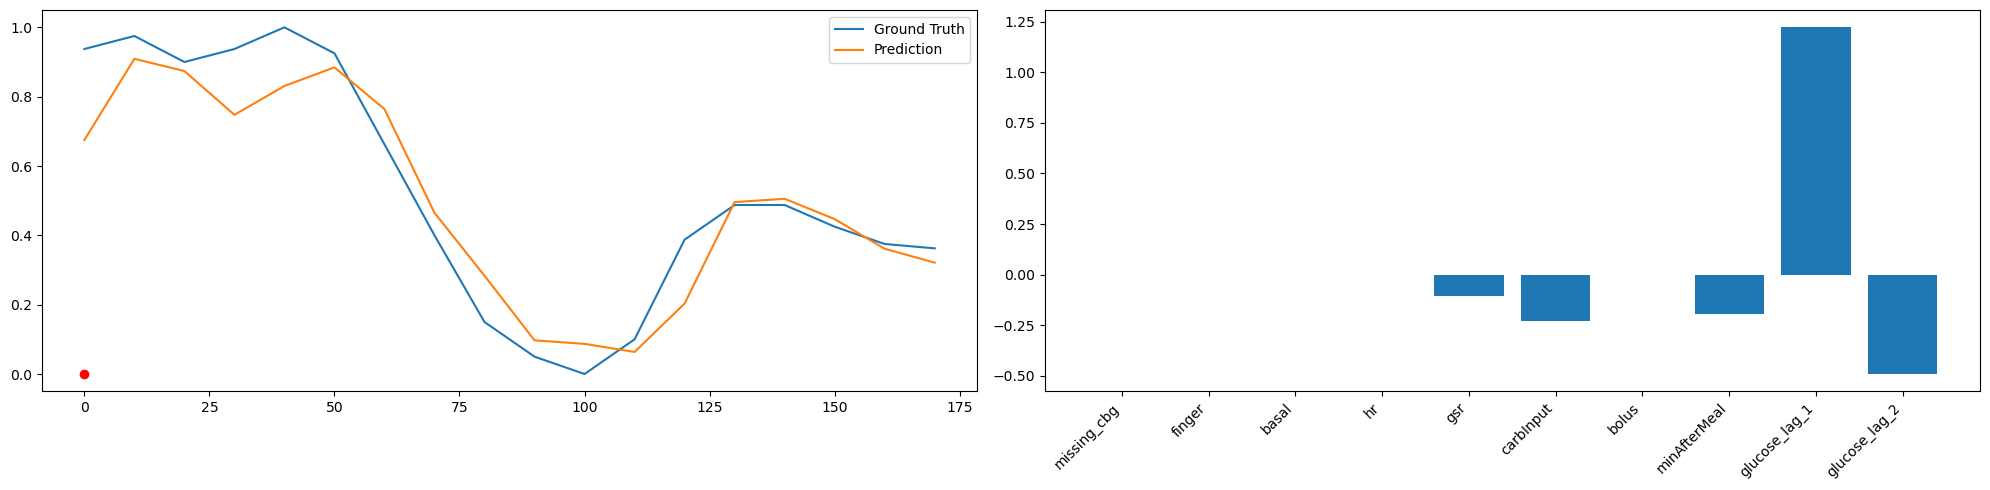

<Figure size 640x480 with 0 Axes>

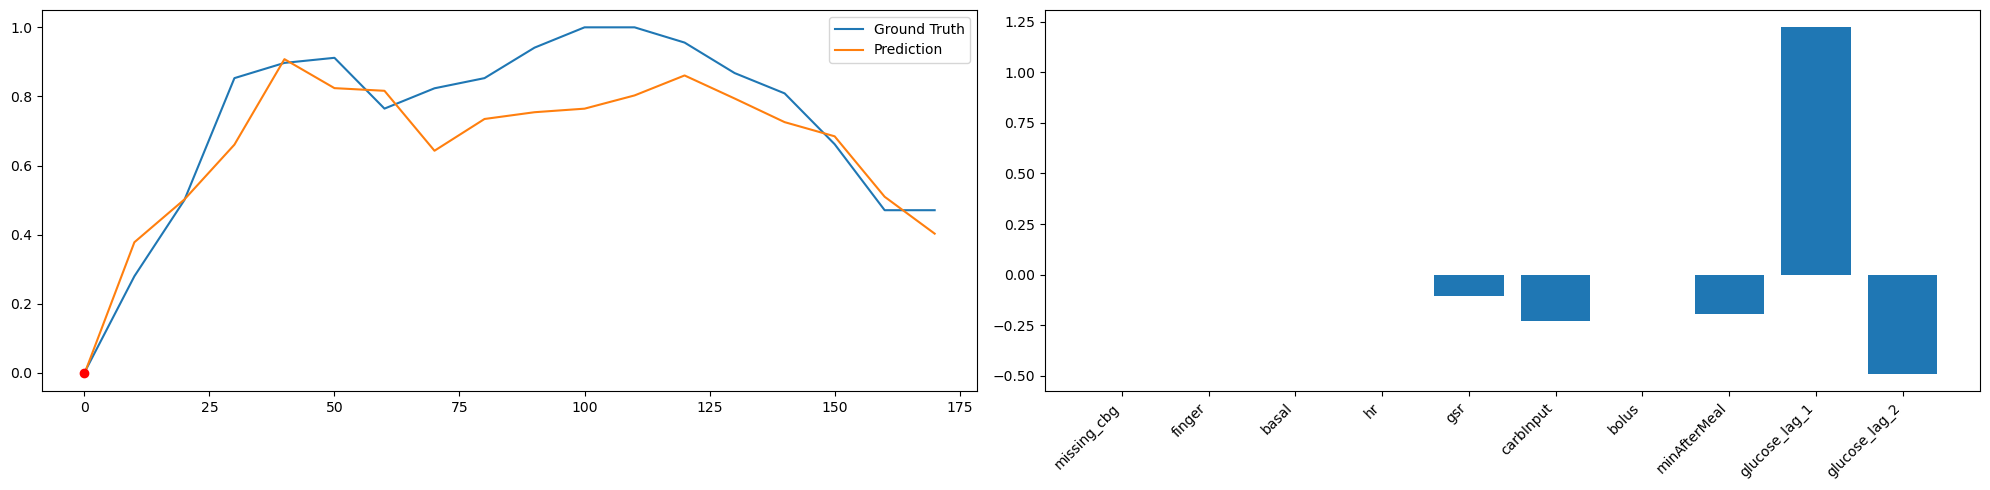

<Figure size 640x480 with 0 Axes>

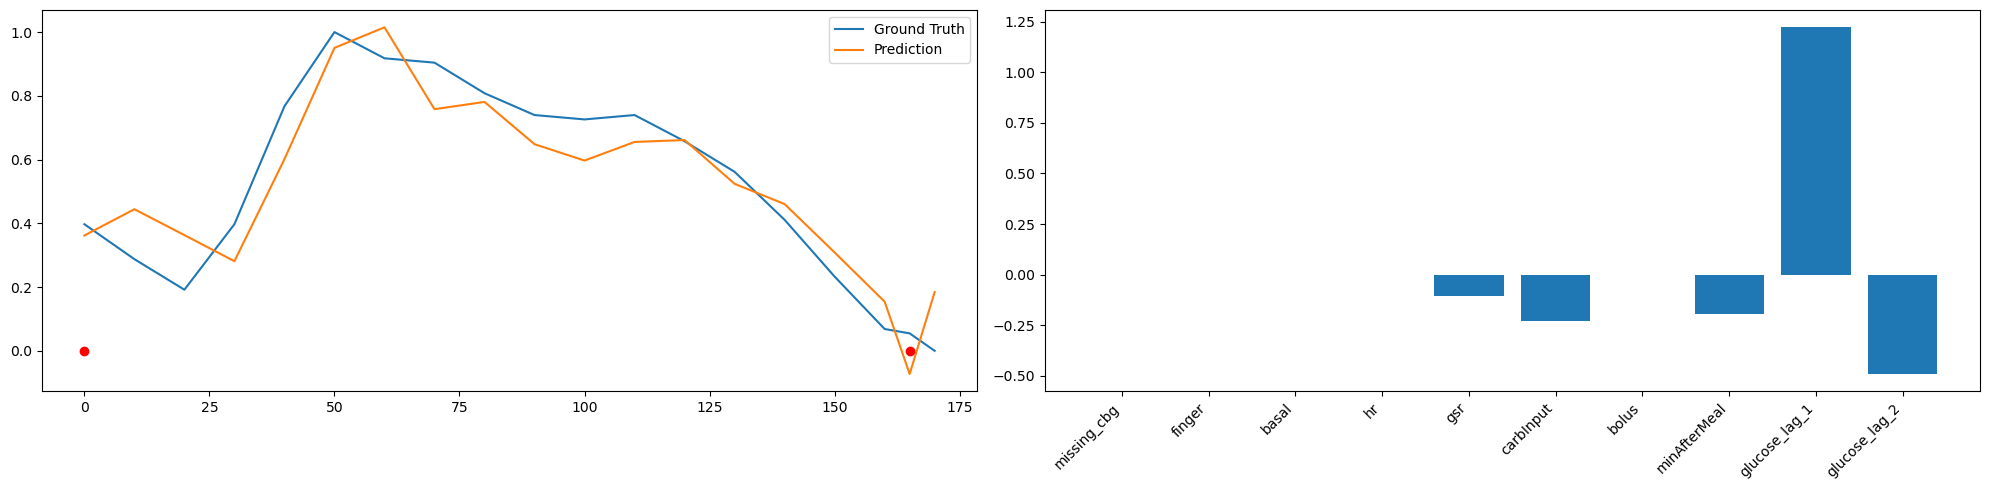

<Figure size 640x480 with 0 Axes>

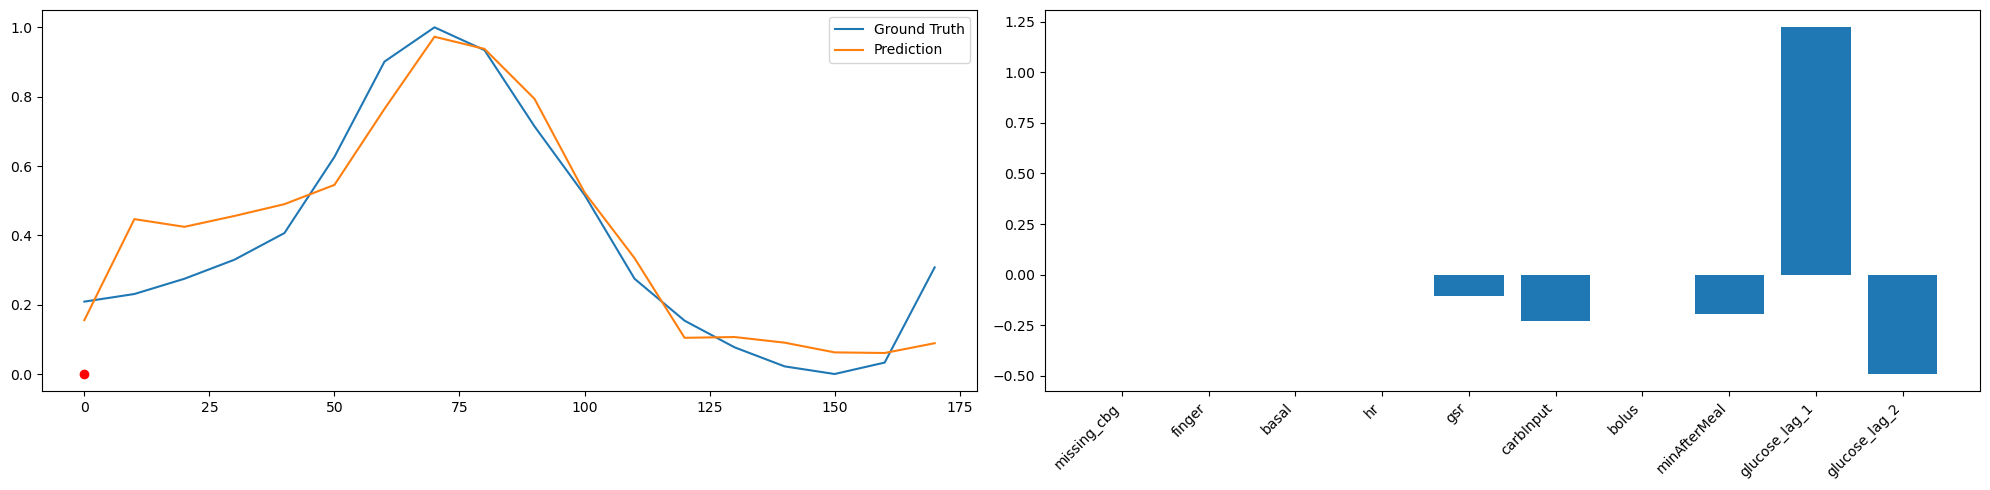

<Figure size 640x480 with 0 Axes>

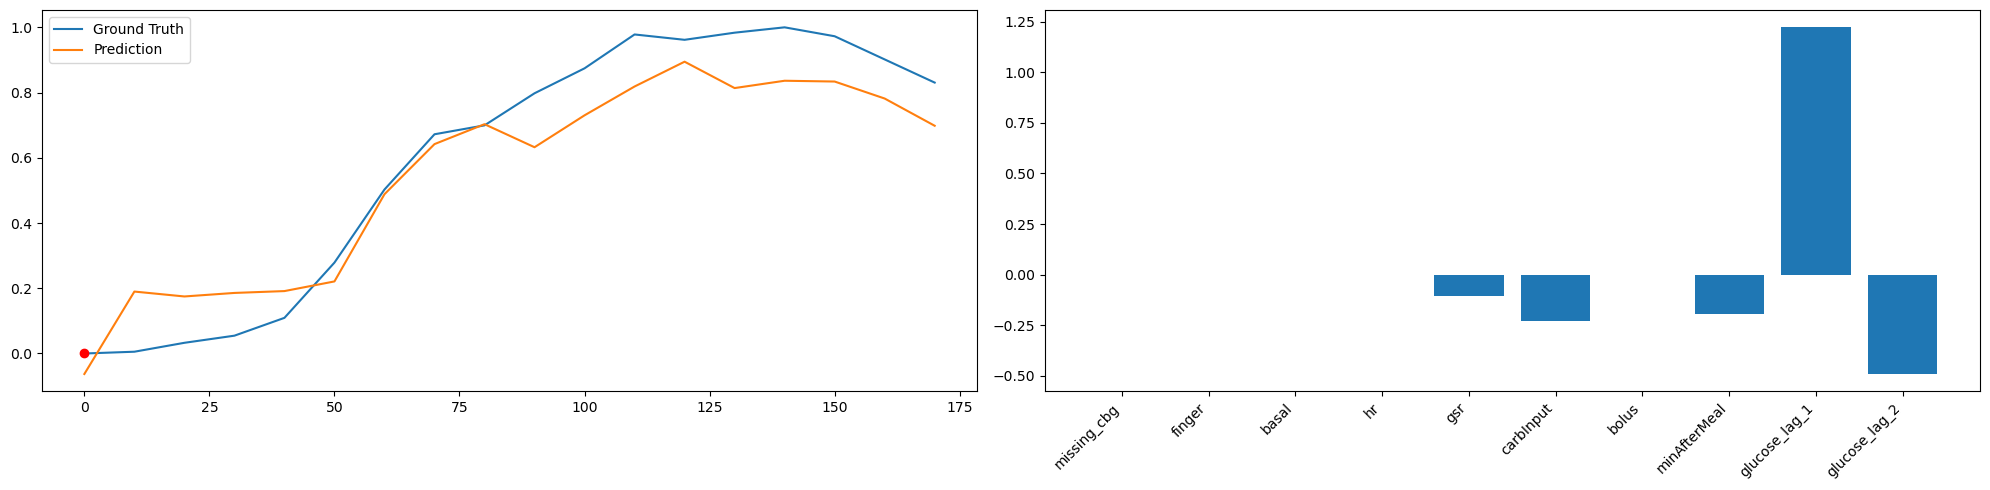

<Figure size 640x480 with 0 Axes>

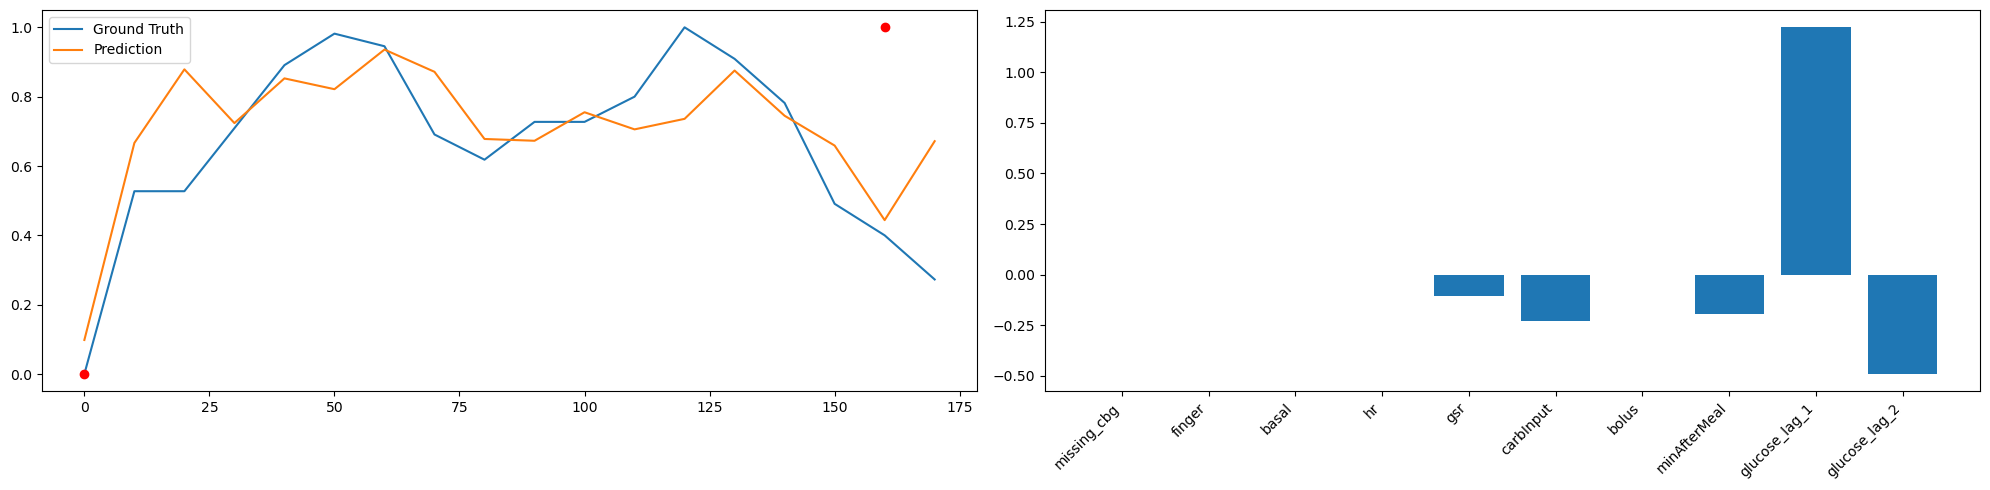

<Figure size 640x480 with 0 Axes>

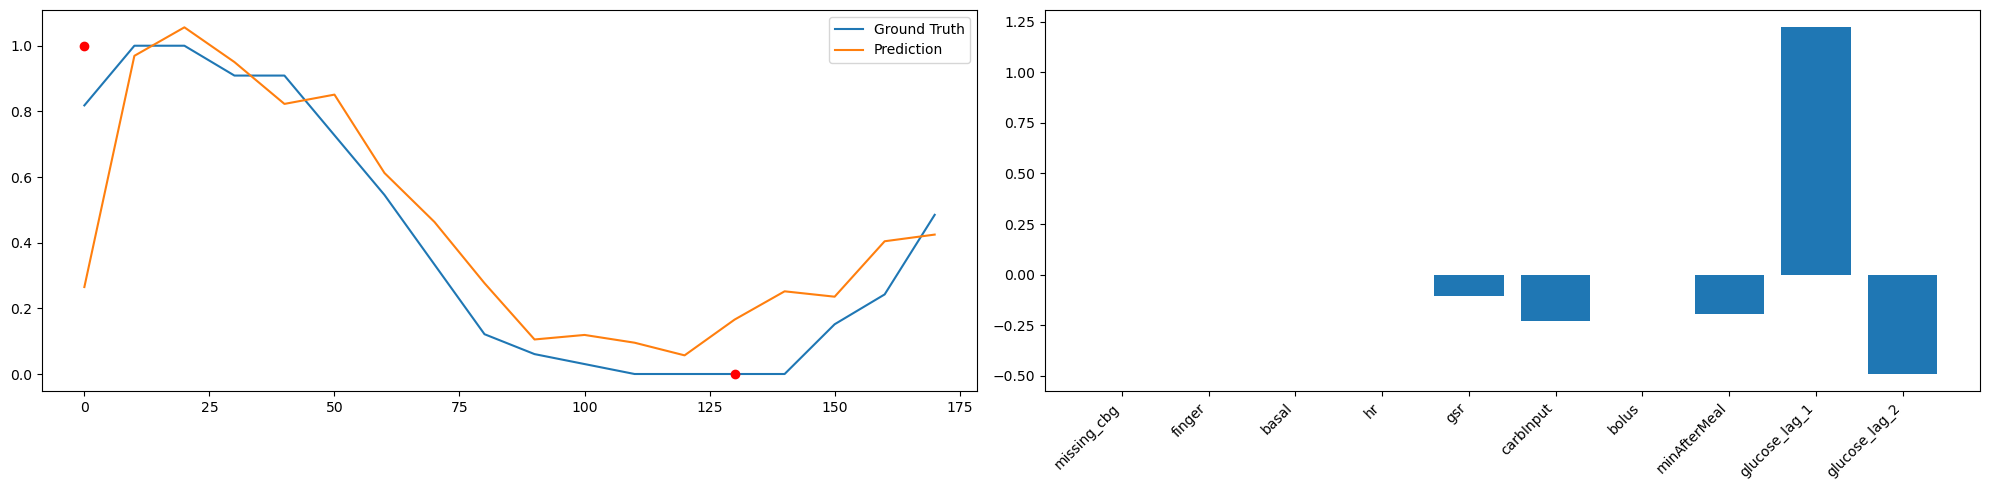

<Figure size 640x480 with 0 Axes>

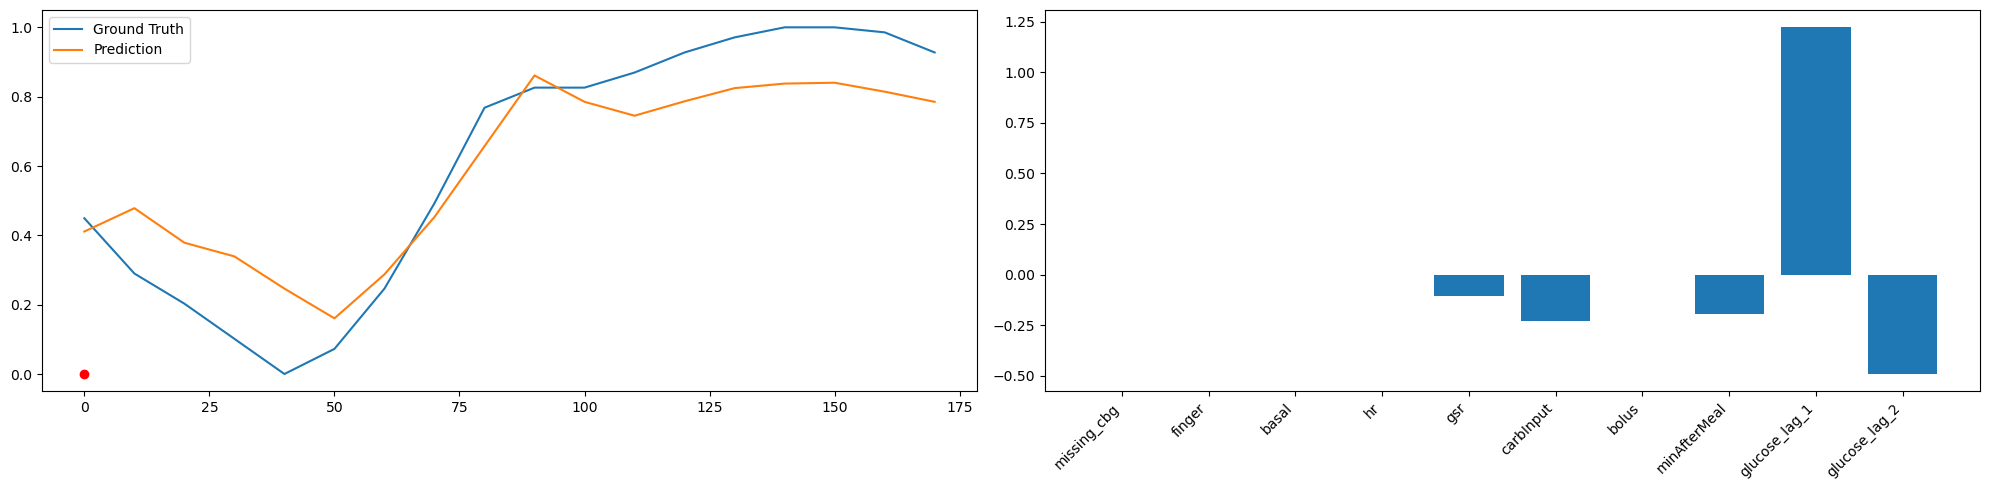

<Figure size 640x480 with 0 Axes>

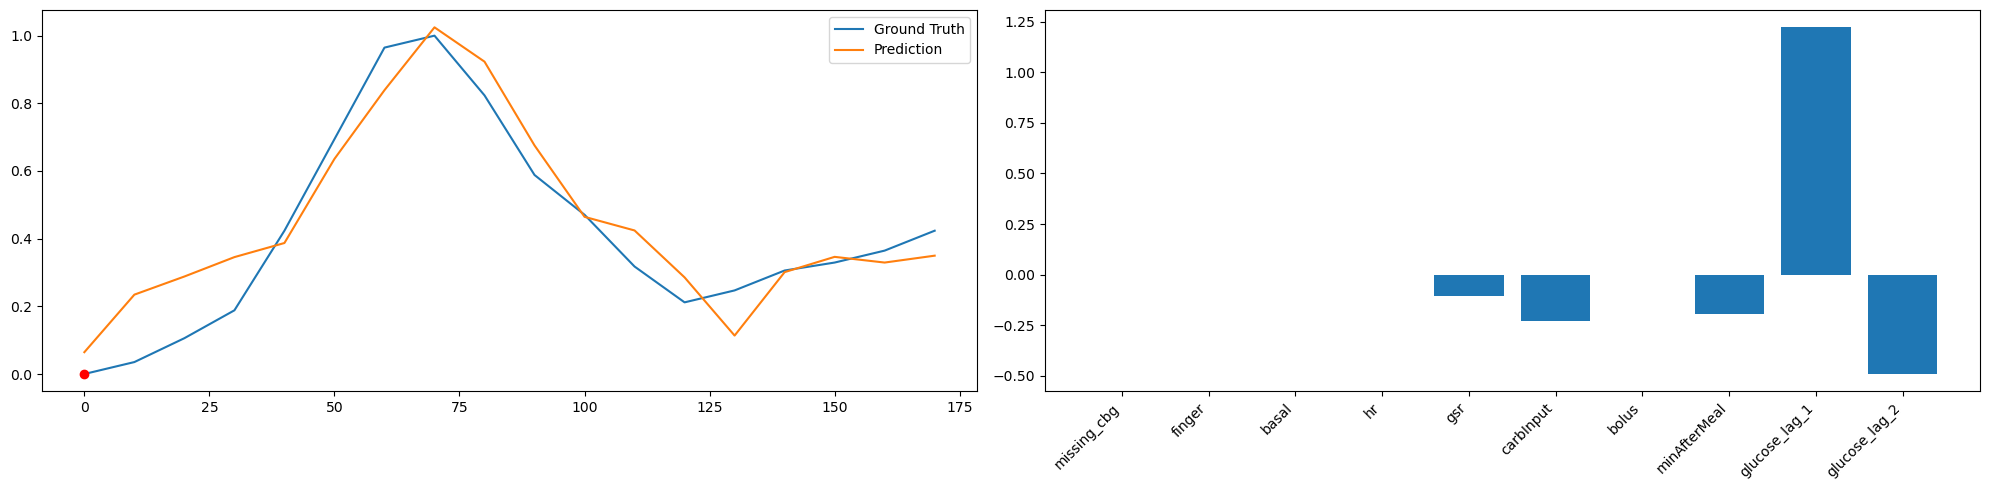

<Figure size 640x480 with 0 Axes>

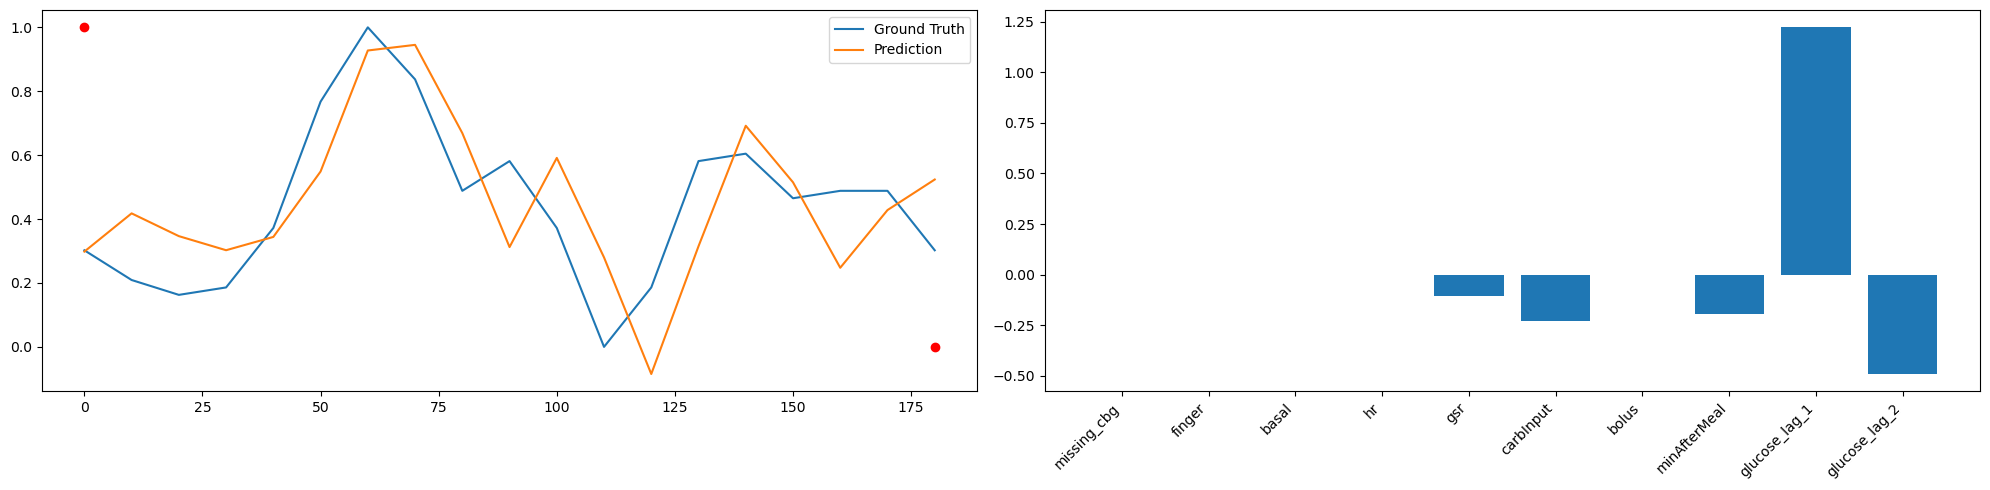

<Figure size 640x480 with 0 Axes>

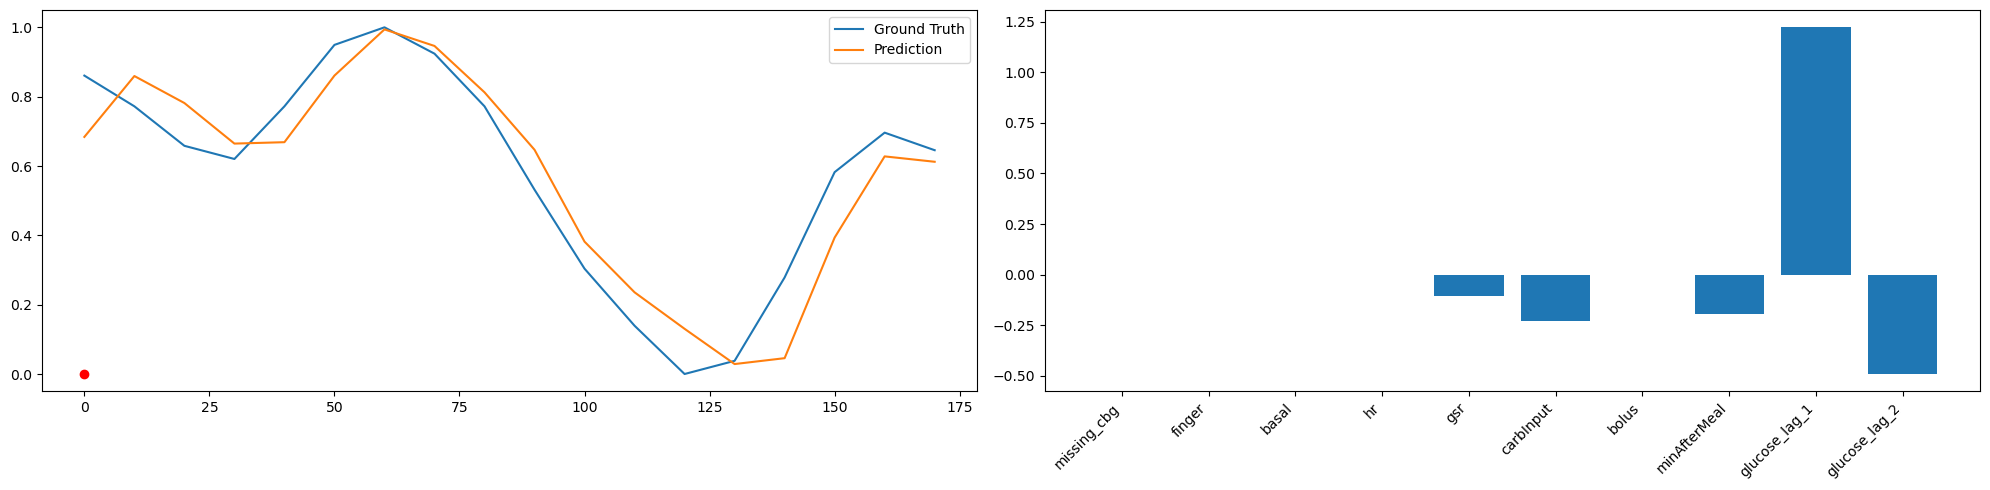

<Figure size 640x480 with 0 Axes>

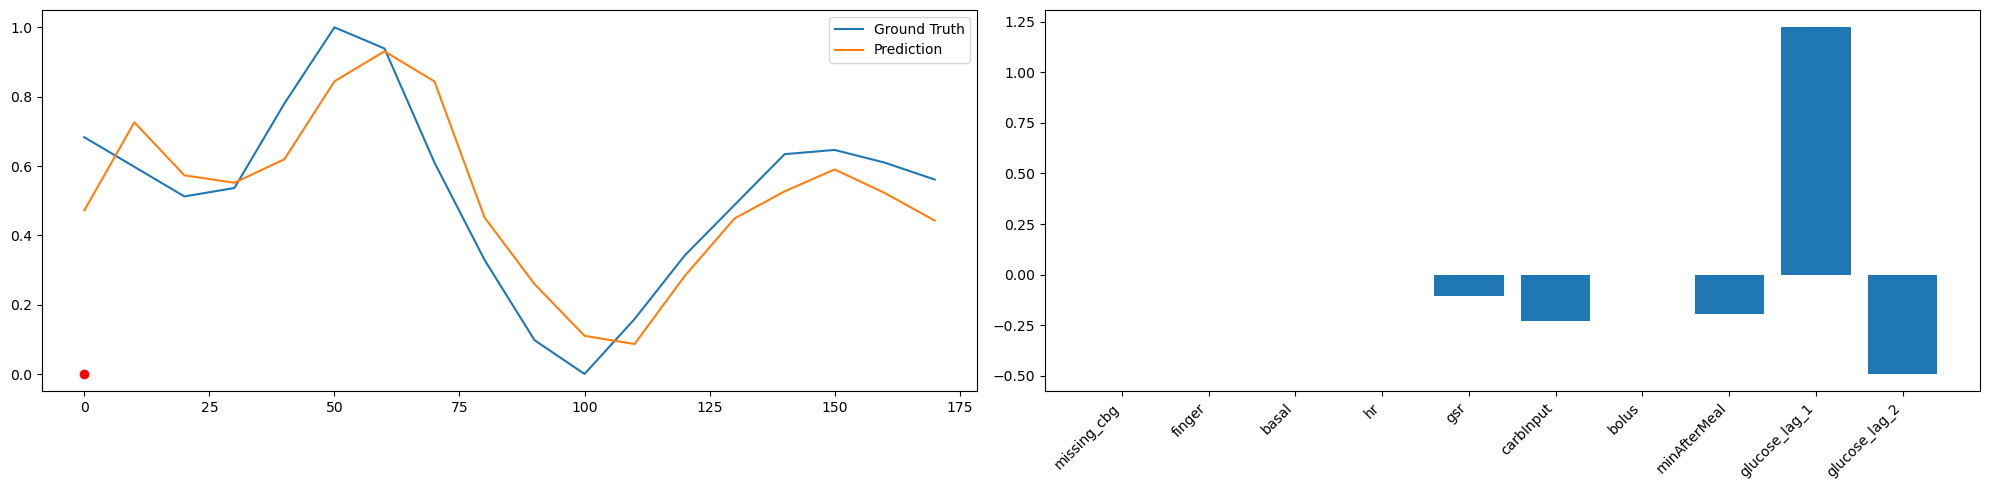

<Figure size 640x480 with 0 Axes>

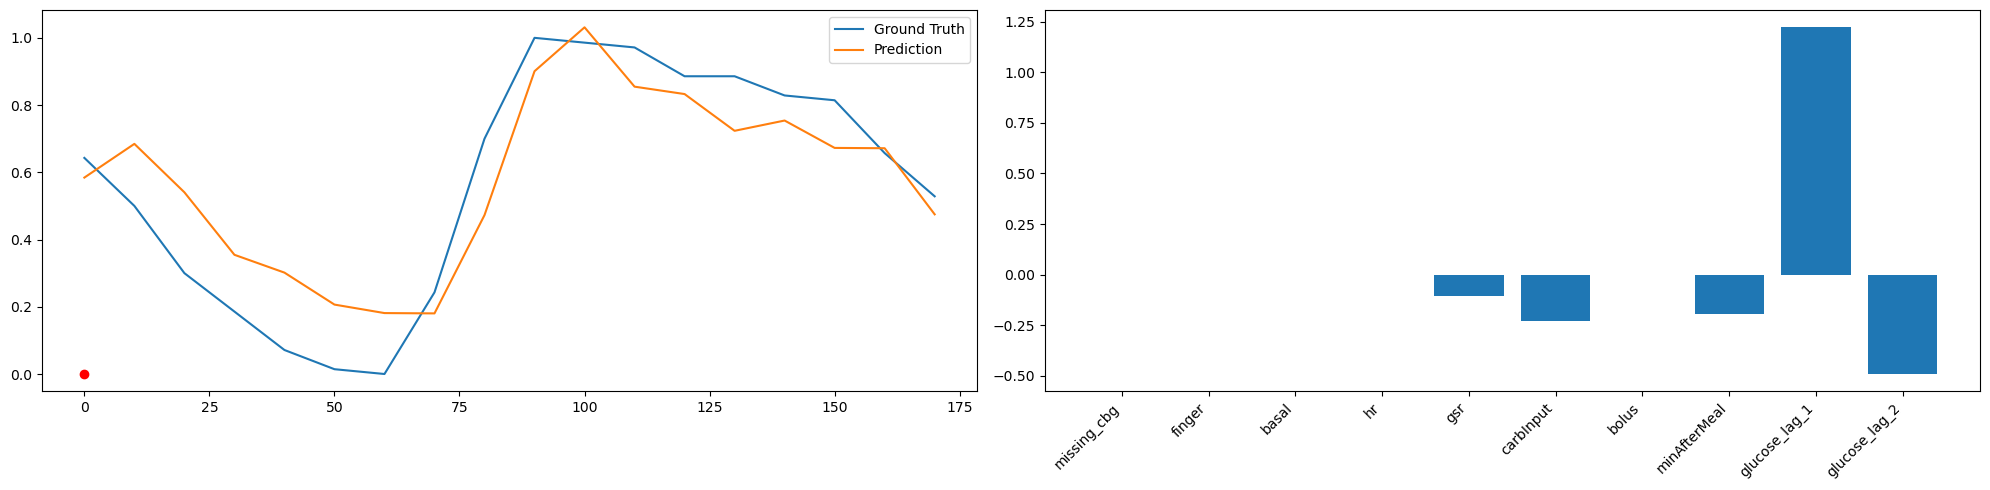

In [320]:
ensemble_model = LinearRegression()
ensemble_model.coef_ = averageCoef
for data in X_test:
    plt.figure()
    train_model(data, model, train=False)
    